#### Capstone Project
Arthur: Wilson Lau
Date: 2015 November

### Capstone Milestone Report

## Introduction
The problem I want to tackle in my capstone project is to detect investment opportunities for cash flow real estate property.  

## The Problem
Real estate investment is a passive income opportunity for investors to accumulate return without active management.  Huge long term appreciation is very much possible for real estate.  However, appreciation often happens in short period of time and the appreciation is heavily affected local market condition.  It is difficult for out-of-the-market investors to detect the trend and acquire properties before price goes up.  My capstone project is trying to help investors to detect real estate investment opportunities and be able to predict which zip code will experience long term appreciation in the near future. 

My project is divided into two stages:

# Stage One
- the first stage is to use anomaly detection technique to discover which zipcodes have success sprike of upward price appreciation. 
- The Anomaly detection is compared new monthly updated home price with historical price as well as comparing with the home price of the surrending areas based on neighborhoods, city, menpolian area, and state.

# Stage Two
- Based on the result of stage one, more data will be collected for the zipcodes that have sudden increase of home price.  
- Those new dataset will be used to figure out what feature contributes to the price appreciation and a predictive model will be created using those features. 

## Dateset
Dataset used is downloaded from Quandl's Zillow data.  This dataset is a monthly time series recording the change of home price. 

# What important fields and information does the data set have?
The important columns for this dataset is time(date end of the month), home price and zipcode. 



# What are its limitations i.e. what are some questions that you cannot answer with this data set?
This dataset actually have 22 columns.  For example, it has columns for different home size e.g. 1 bedroom, 2 bedroom, 3 bedroom, price per square foot, average listing price, etc...  Since it seems that most of these columns are highly corelate to home price, they may be very help for predicting home price. 

# What kind of cleaning and wrangling did you need to do?
Quandl's API is very powerful and very flexible.  At the same time, it is a bit complicated to pull the home price.  One way to pull home price is to pass zipcode as input parameter, and Quandl will return the historical price data with all the columns related to that zipcode.  So, to get the data, I will need to use a zipcode dataset that contains all the zipcode of the US and then use the Quandl API to pull data one zipcode at a time. 

# Are there other datasets you can find, use and combine with, to answer the questions that matter?
To order to group home price data by city, state, etc.., I will need to find other dataset that relates individual zipcodes with their city name and state name.  I will need to merge the dataset together in order to find out which zipcode belongs to which city or state. 

## Preliminary Findings and Hypothesis test.
.....






In [6]:
''' Problem: Try to find which zipcode and in which months has its price increase sigificantly higher than the mean price with
the same zipcode and also than the rest of the zipcode. '''

#load home price data into dataframe
import numpy as np
import pandas as pd
import pickle
from scipy import stats
import os
import glob
from os import path
import dateUtility
import datetime as dt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row', 1000)

def trim_fraction(text):
    if '.0' in text:
        return text[:text.rfind('.0')]
    return text

#load home price data from Datafiles
# df = pickle.load( open( ".\DataPfiles\93063_to_93524.p", "rb" ) ) 
df = pd.DataFrame()
for filename in glob.glob(os.path.join('.\\DataPfiles\\', '9*.p')):
    df = pd.concat([df, pd.read_pickle(filename)], axis=0)
# there may be a problem here.  There are only about 1700 zipcode in the .p file although CA has over 2700 zipcode

### Pivot indivudal columns into a new dataframe for analysis: 
### 1) Put 1) All Homes prirce 2) Price-To-Rent Ratio into rows and grouped them by zipcode
df = df.reset_index()
dfAllHomes = df.pivot(index='index', columns='ZipCode', values='All Homes')
dfPriceToRent = df.pivot(index='index', columns='ZipCode', values='Price-to-Rent Ratio')  #I don't make use of this feature now,but will do later

### calcaluate the home price's moving average for every 3 months, with minimal of 3 months
dfAllHomesMovingAve = pd.rolling_mean(dfAllHomes,window=3,min_periods=3)

### shift entire set of Moving Average number downward for one month
### This is needed to line up the previous month moving average with the current month moving average in the same row
dfAllHomesMovingAve = dfAllHomesMovingAve.shift(periods=1,freq=None,axis=0)

### since I shift the all rows for one month earlier, so I can just subtract the two dataframe and calculate the price change.
dfAllHomesDiffFromMovAve = dfAllHomes - dfAllHomesMovingAve #price change
dfAllHomesDiffFromMovAvePercent = (dfAllHomes - dfAllHomesMovingAve)/dfAllHomes.shift(periods=1,freq=None,axis=0) #price percentage change
NumOfMonthForward = 6 #set the number of month to include for calculating the predicting average percentage increase
dfAllHomesDiffFromMovAvePercentMovAve = pd.rolling_mean(dfAllHomesDiffFromMovAvePercent,window=NumOfMonthForward,min_periods=NumOfMonthForward) # calculate the moving average percentage increase for 6 months
dfAllHomesDiffFromMovAvePercentMovAve2 = dfAllHomesDiffFromMovAvePercentMovAve.shift(periods=-(NumOfMonthForward-1),freq=None,axis=0) # shift dataframe upward for 5 record so the current month shows the moving average percentage increase for the next 6 months(including current month)
dfAllHomesStdDevInZipCode = dfAllHomesDiffFromMovAvePercentMovAve2.copy() #dataframe to hold z score within zipcode

##loop through each zipcode column
for x in dfAllHomesStdDevInZipCode.columns:
    if sum(dfAllHomesStdDevInZipCode[x].isnull()) > 0:  # if any month has null value, drop the entire zipcode
        dfAllHomesStdDevInZipCode.drop(x,axis=1)
    dfAllHomesStdDevInZipCode[x] = (dfAllHomesStdDevInZipCode[x] - dfAllHomesStdDevInZipCode[x].mean()) / dfAllHomesStdDevInZipCode[x].std()  #calculate z score for All Homes price each month

##Calculate z score comparing price across zipcode
dfAllHomesStdDevAcrossZipCode = dfAllHomesDiffFromMovAvePercent.copy() #dataframe to hold z score across different zipcode
dfAllHomesStdDevAcrossZipCode['MeanHomePrice'] = dfAllHomesStdDevAcrossZipCode.mean(axis=1)
dfAllHomesStdDevAcrossZipCode['StdDevHomePrice'] = dfAllHomesStdDevAcrossZipCode.std(axis=1)
dfAllHomesStdDevAcrossZipCode = (dfAllHomesStdDevAcrossZipCode - dfAllHomesStdDevAcrossZipCode['MeanHomePrice']) / dfAllHomesStdDevAcrossZipCode['StdDevHomePrice']

##drop the two added columns so that match the dataframe size of df..InZipCode and df..AcrossZipCode
dfAllHomesStdDevAcrossZipCode = dfAllHomesStdDevAcrossZipCode.drop('MeanHomePrice',axis=1)
dfAllHomesStdDevAcrossZipCode = dfAllHomesStdDevAcrossZipCode.drop('StdDevHomePrice',axis=1)

##Abnormally Detection method ONE
##Find out which zipcode and its time frame in the dataframe has z score large than 2 in both df..InZipCode and df..AcrossZipCode dataframe
targetZscore = 1.5
targetZipcodeBoolean = ((dfAllHomesStdDevInZipCode > targetZscore) & (dfAllHomesStdDevAcrossZipCode > targetZscore))
# targetZipCodes = dfAllHomesMovingAve[targetZipcodeBoolean]#.dropna
selectedZipCodes = pd.DataFrame(dfAllHomesMovingAve[targetZipcodeBoolean].sum(axis = 0) > 0)  #find out which zipcodes are over target zscore
selectedZipCodes[selectedZipCodes[0] == True] #extract only the zipcode that are over zscore

### pivot a new dataframe moving targeted zipcodes into index joining the month-end time (multi-level) index
TargetZipCode = pd.DataFrame(targetZipcodeBoolean.stack())  # stack zipcode from column names into column
TargetZipCode.columns = ['PredictZipCode'] # specify columne name
TargetZipCode = pd.DataFrame(TargetZipCode.reset_index()) # move index into column
dfPredictZipCode = pd.merge(df,TargetZipCode,on=['index','ZipCode']) #merge targeted zipcode column for prediction into main dataframe(which is loaded from 9*.p files)
dfPredictZipCode.rename(columns={'index':'Month'}, inplace=True)
dfPredictZipCode['Month'] = dfPredictZipCode['Month'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d'))
dfPredictZipCode.set_index(['Month','ZipCode'],inplace=True)

### Convert dfPredictZipcode.PredictZipCode from boolean to float, so false = 0, true = 1
dfPredictZipCode.ix[dfPredictZipCode.PredictZipCode == False,'PredictZipCode'] = 0;
dfPredictZipCode.ix[dfPredictZipCode.PredictZipCode == True,'PredictZipCode'] = 1;
dfPredictZipCode.PredictZipCode = dfPredictZipCode.PredictZipCode.astype(float)
print sum(dfPredictZipCode.PredictZipCode)


### Clean irsdatafull dataframe by removing np.nan, nan(string), ' '(space) and 0 in the cells and fill those cells with back filling value
# finding dataframe cell with 'nan',' ' and 0 and then turn them into np.nan
for x in dfPredictZipCode.columns:
    if x == 'PredictZipCode':
        print "found predictZipCode"
        break
    nalist = dfPredictZipCode[x].isin(['nan',' ',0])
    dfPredictZipCode.ix[nalist,x] = np.nan

# use fillna funcion to back filling the value from following rows back to rows above
dfPredictZipCode = dfPredictZipCode.reset_index()  
dfPredictZipCode.set_index("Month")
dfPredictZipCode = dfPredictZipCode.fillna(method='bfill')
dfPredictZipCode = dfPredictZipCode.fillna(method='ffill')
dfPredictZipCode = dfPredictZipCode.reset_index()
dfPredictZipCode.set_index(['Month','ZipCode'],inplace=True)
dfPredictZipCode = dfPredictZipCode.drop('index',axis=1)
dfPredictZipCode.head()

#check to see if there is still nan like value in the dataframe
print "Predict Zip:"
print sum(dfPredictZipCode.PredictZipCode)
print "nan:"
print sum(dfPredictZipCode.isin(['nan',' ',0]).values)
print "null value:"
print sum(dfPredictZipCode.isnull().values)

### tasks to do
### process IRS dataaset - DONE
### process Census dataset - DONE
### process proximityone dataset
### apply training model to learn how IRS and Census dataset can predict target zipcodes - DONE
### evaluate and test model by breaking down into training data and test data - DONE
### apply feature scaling to dataset
### use PCA to combine some features e.g. I think I can combine all the home price for different number of bedrooms into one feature
### modify withinZipcode detection not to use z score, but just average monthly price increase over a certain percentage
### use F1 score and some other ways to evaluate the performance of the model
### apply visualization on data; add Google maps to show the results
### rewrite Storytelling





3095.0
found predictZipCode
Predict Zip:
3095.0
nan:
[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0 305422]
null value:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [7]:
# print "nan:"
# print sum(dfAllHomesMovingAve.isin(['nan',' ',0]).values)
# print "null value:"
# print sum(dfAllHomesMovingAve.isnull().values)
# sum(TargetZipCode.PredictZipCode)
dfPredictZipCode1 = pd.DataFrame(dfPredictZipCode.PredictZipCode)
dfPredictZipCode1.unstack(level=1)

PredictZipCode                                                  \
ZipCode             90001 90002 90003 90004 90005 90006 90007 90008 90010   
Month                                                                       
1996-04-30              0     0     0     0     0     0     0     0     0   
1996-05-31              0     0     0     0     0     0     0     0     0   
1996-06-30              0     0     0     0     0     0     0     0     0   
1996-07-31              0     0     0     0     0     0     0     0     0   
1996-08-31              0     0     0     0     0     0     0     0     0   
1996-09-30              0     0     0     0     0     0     0     0     0   
1996-10-31              0     0     0     0     0     0     0     0     0   
1996-11-30              0     0     0     0     0     0     0     0     0   
1996-12-31              0     0     0     0     0     0     0     0     0   
1997-01-31              0     0     0     0     0     0     0     0     0   
1997-02-28              0     0     0     0     0     0     0     0     0   
1997-03-31              0     0     0     0     0     0     0     0     0   
1997-04-30              0     0     0     0     0     0     0     0     0   
1997-05-31              0     0     0     0     0     0     0     0     0   
1997-06-30              0     0     0     1     0     0     0     0     0   
1997-07-31              0     0     0     1     0     0     0     0     0   
1997-08-31              0     0     0     0     0     0     0     0     0   
1997-09-30              0     0     0     0     0     0     0     0     0   
1997-10-31              0     0     0     0     0     0     0     0     0   
1997-11-30              0     0     0     0     0     0     0     0     0   
1997-12-31              0     0     0     0     0     0     0     0     0   
1998-01-31              0     0     0     0     0     0     0     0     0   
1998-02-28              0     0     0     0     0     0     0     0     0   
1998-03-31              0     0     0     0     0     0     0     0     0   
1998-04-30              0     0     0     0     0     0     0     0     0   
1998-05-31              0     0     0     0     0     0     0     0     0   
1998-06-30              0     0     0     0     0     0     0     0     0   
1998-07-31              0     0     0     0     0     0     0     0     0   
1998-08-31              0     0     0     0     0     0     0     0     0   
1998-09-30              0     0     0     0     0     0     0     0     0   
1998-10-31              0     0     0     0     0     0     0     0     0   
1998-11-30              0     0     0     0     0     0     0     0     0   
1998-12-31              0     0     0     0     0     0     0     0     0   
1999-01-31              0     0     0     0     0     0     0     0     0   
1999-02-28              0     0     0     0     0     0     0     0     0   
1999-03-31              0     0     0     0     0     0     0     0     0   
1999-04-30              0     0     0     0     0     0     0     0     0   
1999-05-31              0     0     0     0     0     0     0     0     0   
1999-06-30              0     0     0     0     0     0     0     0     0   
1999-07-31              0     0     0     0     0     0     0     0     0   
1999-08-31              0     0     0     0     0     0     0     0     0   
1999-09-30              0     0     0     0     0     0     0     0     0   
1999-10-31              0     0     0     0     0     0     0     0     0   
1999-11-30              0     0     0     0     0     0     0     0     0   
1999-12-31              0     0     0     0     0     0     0     0     0   
2000-01-31              0     0     0     0     0     0     0     0     0   
2000-02-29              0     0     0     0     0     0     0     0     0   
2000-03-31              0     0     0     0     0     0     0     0     0   
2000-04-30              0     0     0     0     0     0     0     0     0   
2000-05

In [8]:
dfPredictZipCodetest1 = dfPredictZipCode.reset_index()
dfPredictZipCodetest1[dfPredictZipCodetest1.ZipCode == '96097']

Month ZipCode  All Homes  1 Bedroom  \
303941  1996-04-30   96097      76900     139800   
303942  1996-05-31   96097      77300     139800   
303943  1996-06-30   96097      77700     139800   
303944  1996-07-31   96097      77900     139800   
303945  1996-08-31   96097      78800     139800   
303946  1996-09-30   96097      79700     139800   
303947  1996-10-31   96097      80200     139800   
303948  1996-11-30   96097      81200     139800   
303949  1996-12-31   96097      82300     139800   
303950  1997-01-31   96097      82500     139800   
303951  1997-02-28   96097      82400     139800   
303952  1997-03-31   96097      82900     139800   
303953  1997-04-30   96097      83100     139800   
303954  1997-05-31   96097      83100     139800   
303955  1997-06-30   96097      83500     139800   
303956  1997-07-31   96097      83600     139800   
303957  1997-08-31   96097      82800     139800   
303958  1997-09-30   96097      82100     139800   
303959  1997-10-31   96097      81600     139800   
303960  1997-11-30   96097      81100     139800   
303961  1997-12-31   96097      81000     139800   
303962  1998-01-31   96097      81500     139800   
303963  1998-02-28   96097      82400     139800   
303964  1998-03-31   96097      83500     139800   
303965  1998-04-30   96097      86200     139800   
303966  1998-05-31   96097      89300     139800   
303967  1998-06-30   96097      89300     139800   
303968  1998-07-31   96097      89300     139800   
303969  1998-08-31   96097      90300     139800   
303970  1998-09-30   96097      89400     139800   
303971  1998-10-31   96097      89500     139800   
303972  1998-11-30   96097      90300     139800   
303973  1998-12-31   96097      91300     139800   
303974  1999-01-31   96097      92300     139800   
303975  1999-02-28   96097      93300     139800   
303976  1999-03-31   96097      93800     139800   
303977  1999-04-30   96097      92900     139800   
303978  1999-05-31   96097      91200     139800   
303979  1999-06-30   96097      88200     139800   
303980  1999-07-31   96097      85400     139800   
303981  1999-08-31   96097      85300     139800   
303982  1999-09-30   96097      87300     139800   
303983  1999-10-31   96097      87900     139800   
303984  1999-11-30   96097      86700     139800   
303985  1999-12-31   96097      84900     139800   
303986  2000-01-31   96097      83900     139800   
303987  2000-02-29   96097      84000     139800   
303988  2000-03-31   96097      84500     139800   
303989  2000-04-30   96097      85100     139800   
303990  2000-05-31   96097      86200     139800   
303991  2000-06-30   96097      86900     139800   
303992  2000-07-31   96097      87400     139800   
303993  2000-08-31   96097      87600     139800   
303994  2000-09-30   96097      88200     139800   
303995  2000-10-31   96097      89600     139800   
303996  2000-11-30   96097      90800     139800   
303997  2000-12-31   96097      91200     139800   
303998  2001-01-31   96097      91700     139800   
303999  2001-02-28   96097      92200     139800   
304000  2001-03-31   96097      92900     139800   
304001  2001-04-30   96097      94100     139800   
304002  2001-05-31   96097      95200     139800   
304003  2001-06-30   96097      95500     139800   
304004  2001-07-31   96097      95200     139800   
304005  2001-08-31   96097      95300     139800   
304006  2001-09-30   96097      95200     139800   
304007  2001-10-31   96097      94900     139800   
304008  2001-11-30   96097      95200     139800   
304009  2001-12-31   96097      97200     139800   
304010  2002-01-31   96097      99300     139800   
304011  2002-02-28   96097     100800     139800   
304012  2002-03-31   96097     102000     139800   
304013  2002-04-30   96097     103000     139800   
304014  2002-05-31   96097     104200     139800   
304015  2002-06-30   96097     106300     139800   
304016  2002-07-31   96097     108200     139800   
304017  2

In [9]:
# sum(dfPredictZipCodeFinalnotstack.PredictZipCode.isnull().values)


In [10]:
###########process IRS dataset
### prepare 1998 IRS data
irsdata = pd.read_csv('./DataPfiles/98zp05ca.csv',header=4, na_values=['**','--'])
irsCol = ['ZipCode','NumberOfReturns','ExemptionsRtn','DepedentExemptionsAmt','AGI','SalariesWagesRtn','SalariesWagesAmt', \
          'TaxableInterestRtn','TaxableInterestAmt', \
          'TotalTaxRtn','TotalTaxAmt','ScheduleCTotalRtn','ScheduleCTotalAmt','ScheduleFTotalRtn','ScheduleFTotalAmt',\
          'ScheduleARtn','ScheduleAAmt'
          ]
# irsCol = ['ZipCode','NumberOfReturns','ExemptionsRtn','DepedentExemptionsAmt','AGI','SalariesWagesRtn','SalariesWagesAmt', \
#           'TaxableInterestRtn','TaxableInterestAmt','EarnedIncomeCreditRtn','EarnedIncomeCreditAmt', \
#           'TotalTaxRtn','TotalTaxAmt','ScheduleCTotalRtn','ScheduleCTotalScheduleC','ScheduleFTotalRtn','ScheduleFTotalScheduleF',\
#           'ScheduleARtn','ScheduleAAmt'
#           ]
irsdata.columns= irsCol #assign column names to dataframe
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].apply(trim_fraction) #remove the decimals from the string object
chars_to_remove = ['*', '**', '--',',']
for col in irsdata.columns: #clean up data by removing non numeric characters
    irsdata[col] = irsdata[col].str.translate(None, ''.join(chars_to_remove))

zipcode = pd.read_csv('./DataPfiles/us_postal_codes.csv')
calzipcode = zipcode[zipcode.State == 'California']
# print irsdata.columns
# print calzipcode.columns
# print irsdata.ZipCode
irsdata['ZipCode'] = irsdata['ZipCode'].str.strip()  #strip white space in the cell
print sum(irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str)))  #match the rows in irsdata with calzipcode
irsdata1998 = irsdata[irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str))]
irsdata1998['AverageAGI'] = irsdata1998.AGI.astype(int) #/ irsdata1998['NumberOfReturns'])
irsdata1998['NumberOfReturns'] = irsdata1998['NumberOfReturns'].astype(int)
irsdata1998['AverageAGI'] = irsdata1998['AverageAGI'] * 1000 / irsdata1998.NumberOfReturns

irsdata1998full = pd.DataFrame(columns=irsdata1998.columns.to_series().append(pd.Series("Month")))
# irsdata1998full = irsdata1998.copy()

for x in range(0,irsdata1998.shape[0]):
    listtemp = []
    irsdata1998t = pd.DataFrame(columns=irsdata1998.columns)
    irsdata1998t = irsdata1998t.append([irsdata1998.iloc[x]]*12,ignore_index=True)
    for i in range(12):
        thisMonth = ("0%i"%(i+1,))[-2:]
        d = dateUtility.mkDateTime("1998-%s-02"%thisMonth)
#         print dateUtility.mkLastOfMonth(d).strftime("%Y-%m-%d")
        listtemp.append(dateUtility.mkLastOfMonth(d).strftime("%Y-%m-%d"))
    irsdata1998t["Month"] = pd.Series(listtemp)
    irsdata1998full = irsdata1998full.append(irsdata1998t, ignore_index=True)

irsdata1998full.set_index(['Month','ZipCode'],inplace=True)  #set dataframe index to match with zipcode price dataframe
irsdata1998small = irsdata1998full[irsdata1998full.index.get_level_values('Month') == '1998-03-31']
irsdata1998small2 = irsdata1998full[irsdata1998full.index.get_level_values('ZipCode') == '90011']

# irsdata1998small = irsdata1998full[irsdata1998full.index.get_level_values('Month') == '1998-03-31']
### merge IRS data with zipcode price data
irsdatafull = irsdata1998full
print "done"
# dfPredictZipCodesmall = dfPredictZipCode[dfPredictZipCode.index.get_level_values('Month') == '1998-03-31']
# dfPredictZipCodesmall = pd.concat([dfPredictZipCodesmall.unstack(level=1),irsdata1998small.unstack(level=1)], axis=1)
# dfPredictZipCodesmall.stack(level=1)

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2396
done


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
### prepare 2001 IRS data
irsdata = pd.read_csv('./DataPfiles/01zp05ca.csv',header=4, na_values=['**','--'])
irsCol = ['ZipCode','NumberOfReturns','ExemptionsRtn','DepedentExemptionsAmt','AGI','SalariesWagesRtn','SalariesWagesAmt', \
          'TaxableInterestRtn','TaxableInterestAmt', \
          'TotalTaxRtn','TotalTaxAmt','ScheduleCTotalRtn','ScheduleCTotalAmt','ScheduleFTotalRtn','ScheduleFTotalAmt',\
          'ScheduleARtn','ScheduleAAmt'
          ]
irsdata.columns= irsCol
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].apply(trim_fraction) #remove the decimals from the string object
chars_to_remove = ['*', '**', '--',',']
for col in irsdata.columns:
    irsdata[col] = irsdata[col].str.translate(None, ''.join(chars_to_remove))

zipcode = pd.read_csv('./DataPfiles/us_postal_codes.csv')
calzipcode = zipcode[zipcode.State == 'California']
# print irsdata.columns
# print calzipcode.columns
# print irsdata.ZipCode
irsdata['ZipCode'] = irsdata['ZipCode'].str.strip()  #strip white space in the cell
print sum(irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str)))  #match the rows in irsdata with calzipcode
irsdata2001 = irsdata[irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str))]
irsdata2001['AverageAGI'] = irsdata2001.AGI.astype(int) #/ irsdata1998['NumberOfReturns'])
irsdata2001['NumberOfReturns'] = irsdata2001['NumberOfReturns'].astype(int)
irsdata2001['AverageAGI'] = irsdata2001['AverageAGI'] * 1000 / irsdata2001.NumberOfReturns
print irsdata2001['AverageAGI'].mean()

irsdata2001full = pd.DataFrame(columns=irsdata2001.columns.to_series().append(pd.Series("Month")))
# irsdata1998full = irsdata1998.copy()

for x in range(0,irsdata2001.shape[0]):
    listtemp = []
    irsdata2001t = pd.DataFrame(columns=irsdata2001.columns)
    irsdata2001t = irsdata2001t.append([irsdata2001.iloc[x]]*12,ignore_index=True)
    for i in range(12):
        thisMonth = ("0%i"%(i+1,))[-2:]
        d = dateUtility.mkDateTime("2001-%s-02"%thisMonth)
        listtemp.append(dateUtility.mkLastOfMonth(d).strftime("%Y-%m-%d"))
    irsdata2001t["Month"] = pd.Series(listtemp)
    irsdata2001full = irsdata2001full.append(irsdata2001t, ignore_index=True)
    
irsdata2001full.set_index(['Month','ZipCode'],inplace=True)  #set dataframe index to match with zipcode price dataframe

### merge IRS data with zipcode price data
irsdatafull = irsdatafull.append(irsdata2001full)
# dfPredictZipCodeFinal = pd.concat([dfPredictZipCode.unstack(level=1),irsdatafull.unstack(level=1)], axis=1)
# dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1)

# dfPredictZipCodeFinal = pd.concat([dfPredictZipCode.unstack(level=1),irsdata1998full.unstack(level=1)], axis=1)
# dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1)
# dfPredictZipCodeFinal = pd.concat([dfPredictZipCodeFinal.unstack(level=1),irsdata2001full.unstack(level=1)], axis=1)
# dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1)

print "done"
# b = dfPredictZipCodeFinal.index.get_level_values(0) == '1998-09-30'  #for testing the result
# b1 = dfPredictZipCodeFinal.index.get_level_values(0) == '2001-09-30'  #for testing the result
# dfPredictZipCodeFinal[b1]  #for testing the result

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

2412
47996.9858028
done


In [12]:
### prepare 2002 IRS data
irsdata = pd.read_csv('./DataPfiles/zptab02ca.csv',header=4, na_values=['**','--'])
irsCol = ['ZipCode','NumberOfReturns','ExemptionsRtn','DepedentExemptionsAmt','AGI','SalariesWagesRtn','SalariesWagesAmt', \
          'TaxableInterestRtn','TaxableInterestAmt', \
          'TotalTaxRtn','TotalTaxAmt','ScheduleCTotalRtn','ScheduleCTotalAmt','ScheduleFTotalRtn','ScheduleFTotalAmt',\
          'ScheduleARtn','ScheduleAAmt'
          ]
irsdata.columns= irsCol
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].apply(trim_fraction) #remove the decimals from the string object
chars_to_remove = ['*', '**', '--',',']
for col in irsdata.columns:
    irsdata[col] = irsdata[col].str.translate(None, ''.join(chars_to_remove))

zipcode = pd.read_csv('./DataPfiles/us_postal_codes.csv')
calzipcode = zipcode[zipcode.State == 'California']
# print irsdata.columns
# print calzipcode.columns
# print irsdata.ZipCode
irsdata['ZipCode'] = irsdata['ZipCode'].str.strip()  #strip white space in the cell
print sum(irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str)))  #match the rows in irsdata with calzipcode
irsdata2002 = irsdata[irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str))]
irsdata2002['AverageAGI'] = irsdata2002.AGI.astype(int) #/ irsdata2002['NumberOfReturns'])
irsdata2002['NumberOfReturns'] = irsdata2002['NumberOfReturns'].astype(int)
irsdata2002['AverageAGI'] = irsdata2002['AverageAGI'] * 1000 / irsdata2002.NumberOfReturns
print irsdata2002['AverageAGI'].mean()

irsdata2002full = pd.DataFrame(columns=irsdata2002.columns.to_series().append(pd.Series("Month")))

for x in range(0,irsdata2002.shape[0]):
    listtemp = []
    irsdata2002t = pd.DataFrame(columns=irsdata2002.columns)
    irsdata2002t = irsdata2002t.append([irsdata2002.iloc[x]]*12,ignore_index=True)
    for i in range(12):
        thisMonth = ("0%i"%(i+1,))[-2:]
        d = dateUtility.mkDateTime("2002-%s-02"%thisMonth)
        listtemp.append(dateUtility.mkLastOfMonth(d).strftime("%Y-%m-%d"))
    irsdata2002t["Month"] = pd.Series(listtemp)
    irsdata2002full = irsdata2002full.append(irsdata2002t, ignore_index=True)
    
irsdata2002full.set_index(['Month','ZipCode'],inplace=True)  #set dataframe index to match with zipcode price dataframe

### merge IRS data with zipcode price data
irsdatafull = irsdatafull.append(irsdata2002full)
# dfPredictZipCodeFinal = pd.concat([dfPredictZipCode.unstack(level=1),irsdatafull.unstack(level=1)], axis=1)
# dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1) #not concat until all irsdatafull is created
print "done"

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

2414
49689.0262676
done


In [13]:
### prepare 2004 IRS data
irsdata = pd.read_csv('./DataPfiles/ZIPCode2004CA.csv',header=4, na_values=['**','--'])
irsCol = ['ZipCode','NumberOfReturns','ExemptionsRtn','DepedentExemptionsAmt','AGI','SalariesWagesRtn','SalariesWagesAmt', \
          'TaxableInterestRtn','TaxableInterestAmt', \
          'TotalTaxRtn','TotalTaxAmt','ScheduleCTotalRtn','ScheduleCTotalAmt','ScheduleFTotalRtn','ScheduleFTotalAmt',\
          'ScheduleARtn','ScheduleAAmt'
          ]
irsdata.columns= irsCol
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].apply(trim_fraction) #remove the decimals from the string object
chars_to_remove = ['*', '**', '--',',']
for col in irsdata.columns:
    irsdata[col] = irsdata[col].str.translate(None, ''.join(chars_to_remove))

zipcode = pd.read_csv('./DataPfiles/us_postal_codes.csv')
calzipcode = zipcode[zipcode.State == 'California']
irsdata['ZipCode'] = irsdata['ZipCode'].str.strip()  #strip white space in the cell
print sum(irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str)))  #match the rows in irsdata with calzipcode
irsdata2004 = irsdata[irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str))]
irsdata2004['AverageAGI'] = irsdata2004.AGI.astype(int) #/ irsdata2002['NumberOfReturns'])
irsdata2004['NumberOfReturns'] = irsdata2004['NumberOfReturns'].astype(int)
irsdata2004['AverageAGI'] = irsdata2004['AverageAGI'] * 1000 / irsdata2004.NumberOfReturns
print irsdata2004['AverageAGI'].mean()

irsdata2004full = pd.DataFrame(columns=irsdata2004.columns.to_series().append(pd.Series("Month")))

for x in range(0,irsdata2004.shape[0]):
    listtemp = []
    irsdata2004t = pd.DataFrame(columns=irsdata2004.columns)
    irsdata2004t = irsdata2004t.append([irsdata2004.iloc[x]]*12,ignore_index=True)
    for i in range(12):
        thisMonth = ("0%i"%(i+1,))[-2:]
        d = dateUtility.mkDateTime("2004-%s-02"%thisMonth)
        listtemp.append(dateUtility.mkLastOfMonth(d).strftime("%Y-%m-%d"))
    irsdata2004t["Month"] = pd.Series(listtemp)
    irsdata2004full = irsdata2004full.append(irsdata2004t, ignore_index=True)
    
irsdata2004full.set_index(['Month','ZipCode'],inplace=True)  #set dataframe index to match with zipcode price dataframe

### merge IRS data with zipcode price data
irsdatafull = irsdatafull.append(irsdata2004full)
# dfPredictZipCodeFinal = pd.concat([dfPredictZipCode.unstack(level=1),irsdatafull.unstack(level=1)], axis=1)
# dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1)  #not concat until all irsdatafull is created
print "done"

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

2390
52308.0969728
done


In [14]:
### prepare 2005 IRS data
irsdata = pd.read_csv('./DataPfiles/ZIPCode2005CA.csv',header=4, na_values=['**','--'])
irsCol = ['ZipCode','NumberOfReturns','ExemptionsRtn','DepedentExemptionsAmt','AGI','SalariesWagesRtn','SalariesWagesAmt', \
          'TaxableInterestRtn','TaxableInterestAmt', \
          'TotalTaxRtn','TotalTaxAmt','ScheduleCTotalRtn','ScheduleCTotalAmt','ScheduleFTotalRtn','ScheduleFTotalAmt',\
          'ScheduleARtn','ScheduleAAmt'
          ]
irsdata.columns= irsCol
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].apply(trim_fraction) #remove the decimals from the string object
chars_to_remove = ['*', '**', '--',',']
for col in irsdata.columns:
    irsdata[col] = irsdata[col].str.translate(None, ''.join(chars_to_remove))

zipcode = pd.read_csv('./DataPfiles/us_postal_codes.csv')
calzipcode = zipcode[zipcode.State == 'California']

irsdata['ZipCode'] = irsdata['ZipCode'].str.strip()  #strip white space in the cell
print sum(irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str)))  #match the rows in irsdata with calzipcode
irsdata2005 = irsdata[irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str))]
irsdata2005['AverageAGI'] = irsdata2005.AGI.astype(int) #/ irsdata2002['NumberOfReturns'])
irsdata2005['NumberOfReturns'] = irsdata2005['NumberOfReturns'].astype(int)
irsdata2005['AverageAGI'] = irsdata2005['AverageAGI'] * 1000 / irsdata2005.NumberOfReturns
print irsdata2005['AverageAGI'].mean()

irsdata2005full = pd.DataFrame(columns=irsdata2005.columns.to_series().append(pd.Series("Month")))

for x in range(0,irsdata2005.shape[0]):
    listtemp = []
    irsdata2005t = pd.DataFrame(columns=irsdata2005.columns)
    irsdata2005t = irsdata2005t.append([irsdata2005.iloc[x]]*12,ignore_index=True)
    for i in range(12):
        thisMonth = ("0%i"%(i+1,))[-2:]
        d = dateUtility.mkDateTime("2005-%s-02"%thisMonth)
        listtemp.append(dateUtility.mkLastOfMonth(d).strftime("%Y-%m-%d"))
    irsdata2005t["Month"] = pd.Series(listtemp)
    irsdata2005full = irsdata2005full.append(irsdata2005t, ignore_index=True)
    
irsdata2005full.set_index(['Month','ZipCode'],inplace=True)  #set dataframe index to match with zipcode price dataframe

### merge IRS data with zipcode price data
irsdatafull = irsdatafull.append(irsdata2005full)
# dfPredictZipCodeFinal = pd.concat([dfPredictZipCode.unstack(level=1),irsdatafull.unstack(level=1)], axis=1)
# dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1)  #not concat until all irsdatafull is created
print "done"

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

2396
55154.0374922
done


In [15]:
### prepare 2006 IRS data
irsdata = pd.read_csv('./DataPfiles/ZIPCode2006CA.csv',header=4, na_values=['**','--'])
irsCol = ['Range', 'ZipCode','NumberOfReturns','ExemptionsRtn','DepedentExemptionsAmt','AGI','SalariesWagesRtn','SalariesWagesAmt', \
          'TaxableInterestRtn','TaxableInterestAmt', \
          'TotalTaxRtn','TotalTaxAmt','ScheduleCTotalRtn','ScheduleCTotalAmt','ScheduleFTotalRtn','ScheduleFTotalAmt',\
          'ScheduleARtn','ScheduleAAmt'
          ]
irsdata.columns= irsCol
irsdata['ZipCode'] = irsdata['ZipCode'].astype(str)  #convert dtype from float64 to string object
irsdata['ZipCode'] = irsdata['ZipCode'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].apply(trim_fraction) #remove the decimals from the string object
chars_to_remove = ['*', '**', '--',',']
for col in irsdata.columns:
    irsdata[col] = irsdata[col].str.translate(None, ''.join(chars_to_remove))

zipcode = pd.read_csv('./DataPfiles/us_postal_codes.csv')
calzipcode = zipcode[zipcode.State == 'California']

irsdata['ZipCode'] = irsdata['ZipCode'].str.strip()  #strip white space in the cell
print sum(irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str)))  #match the rows in irsdata with calzipcode
irsdata2006 = irsdata[irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str))]

irsdata2006 = irsdata2006[(irsdata2006['Range'] == irsdata2006['ZipCode'])]
irsdata2006 = irsdata2006.drop('Range', axis=1)
irsdata2006['AverageAGI'] = irsdata2006.AGI.astype(int) #/ irsdata2002['NumberOfReturns'])
irsdata2006['NumberOfReturns'] = irsdata2006['NumberOfReturns'].astype(int)
irsdata2006['AverageAGI'] = irsdata2006['AverageAGI'] * 1000 / irsdata2006.NumberOfReturns
print irsdata2006['AverageAGI'].mean()

irsdata2006full = pd.DataFrame(columns=irsdata2006.columns.to_series().append(pd.Series("Month")))

for x in range(0,irsdata2006.shape[0]):
    listtemp = []
    irsdata2006t = pd.DataFrame(columns=irsdata2006.columns)
    irsdata2006t = irsdata2006t.append([irsdata2006.iloc[x]]*12,ignore_index=True)
    for i in range(12):
        thisMonth = ("0%i"%(i+1,))[-2:]
        d = dateUtility.mkDateTime("2006-%s-02"%thisMonth)
        listtemp.append(dateUtility.mkLastOfMonth(d).strftime("%Y-%m-%d"))
    irsdata2006t["Month"] = pd.Series(listtemp)
    irsdata2006full = irsdata2006full.append(irsdata2006t, ignore_index=True)
    
irsdata2006full.set_index(['Month','ZipCode'],inplace=True)  #set dataframe index to match with zipcode price dataframe

### merge IRS data with zipcode price data
irsdatafull = irsdatafull.append(irsdata2006full)
# dfPredictZipCodeFinal = pd.concat([dfPredictZipCode.unstack(level=1),irsdatafull.unstack(level=1)], axis=1)
# dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1)  #not concat until all irsdatafull is created
print "done"

19128
55230.5241484
done


In [16]:
### prepare 2007 IRS data
def trim_fraction(text):
    if '.0' in text:
        return text[:text.rfind('.0')]
    return text

irsdata = pd.read_csv('./DataPfiles/ZIPCode2007CA.csv',header=4, na_values=['**','--'])
irsCol = ['Range', 'ZipCode','NumberOfReturns','ExemptionsRtn','DepedentExemptionsAmt','AGI','SalariesWagesRtn','SalariesWagesAmt', \
          'TaxableInterestRtn','TaxableInterestAmt', \
          'TotalTaxRtn','TotalTaxAmt','ScheduleCTotalRtn','ScheduleCTotalAmt','ScheduleFTotalRtn','ScheduleFTotalAmt',\
          'ScheduleARtn','ScheduleAAmt'
          ]
irsdata.columns= irsCol
irsdata['ZipCode'] = irsdata['ZipCode'].astype(str)  #convert dtype from float64 to string object
irsdata['ZipCode'] = irsdata['ZipCode'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['DepedentExemptionsAmt'] = irsdata['DepedentExemptionsAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['DepedentExemptionsAmt'] = irsdata['DepedentExemptionsAmt'].apply(trim_fraction) #remove the decimals from the string object
chars_to_remove = ['*', '**', '--',',']
for col in irsdata.columns:
    irsdata[col] = irsdata[col].str.translate(None, ''.join(chars_to_remove))

zipcode = pd.read_csv('./DataPfiles/us_postal_codes.csv')
calzipcode = zipcode[zipcode.State == 'California']

irsdata['ZipCode'] = irsdata['ZipCode'].str.strip()  #strip white space in the cell
print sum(irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str)))  #match the rows in irsdata with calzipcode
irsdata2007 = irsdata[irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str))]

irsdata2007 = irsdata2007[pd.isnull(irsdata2007['Range'])]
irsdata2007 = irsdata2007.drop('Range', axis=1)  #it seems that the inplace operation has bug that failed this line, so I removed it. 
irsdata2007['AverageAGI'] = irsdata2007.AGI.astype(int) #/ irsdata2002['NumberOfReturns'])
irsdata2007['NumberOfReturns'] = irsdata2007['NumberOfReturns'].astype(int)
irsdata2007['AverageAGI'] = irsdata2007['AverageAGI'] * 1000 / irsdata2007.NumberOfReturns
print irsdata2007['AverageAGI'].mean()

irsdata2007full = pd.DataFrame(columns=irsdata2007.columns.to_series().append(pd.Series("Month")))

for x in range(0,irsdata2007.shape[0]):
    listtemp = []
    irsdata2007t = pd.DataFrame(columns=irsdata2007.columns)
    irsdata2007t = irsdata2007t.append([irsdata2007.iloc[x]]*12,ignore_index=True)
    for i in range(12):
        thisMonth = ("0%i"%(i+1,))[-2:]
        d = dateUtility.mkDateTime("2007-%s-02"%thisMonth)
        listtemp.append(dateUtility.mkLastOfMonth(d).strftime("%Y-%m-%d"))
    irsdata2007t["Month"] = pd.Series(listtemp)
    irsdata2007full = irsdata2007full.append(irsdata2007t, ignore_index=True)
    
irsdata2007full.set_index(['Month','ZipCode'],inplace=True)  #set dataframe index to match with zipcode price dataframe

### merge IRS data with zipcode price data
irsdatafull = irsdatafull.append(irsdata2007full)
# dfPredictZipCodeFinal = pd.concat([dfPredictZipCode.unstack(level=1),irsdatafull.unstack(level=1)], axis=1)
# dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1)   #not concat until all irsdatafull is created

19176
52460.2197889


In [17]:
### prepare 2008 IRS data
def trim_fraction(text):
    if '.0' in text:
        return text[:text.rfind('.0')]
    return text

irsdata = pd.read_csv('./DataPfiles/08zp05ca.csv',header=4, na_values=['**','--'])
# irsdata = pd.read_csv('./DataPfiles/08zp05ca.csv',header=4, na_values=['**','--'], \
#                       dtype={'Range': np.str, 'ZipCode': np.str, 'NumberOfReturns': np.str, \
#                             'ExemptionsRtn':np.str, 'DepedentExemptionsAmt':np.str,'AGI':np.str,'SalariesWagesRtn':np.str, \
#                             'SalariesWagesAmt':np.str,'TaxableInterestRtn':np.str, 'TaxableInterestAmt':np.str, \
#                             'TotalTaxRtn':np.str, 'TotalTaxAmt':np.str, 'ScheduleCTotalRtn': np.str,'ScheduleCTotalAmt':np.str, \
#                             'ScheduleFTotalRtn':np.str, 'ScheduleFTotalAmt':np.str, 'ScheduleARtn':np.str,'ScheduleAAmt':np.str}
#                       ) 
irsCol = ['Range', 'ZipCode','NumberOfReturns','ExemptionsRtn','DepedentExemptionsAmt','AGI','SalariesWagesRtn','SalariesWagesAmt', \
          'TaxableInterestRtn','TaxableInterestAmt', \
          'TotalTaxRtn','TotalTaxAmt','ScheduleCTotalRtn','ScheduleCTotalAmt','ScheduleFTotalRtn','ScheduleFTotalAmt',\
          'ScheduleARtn','ScheduleAAmt'
          ]
irsdata.columns= irsCol

for x in irsdata.columns:
    irsdata[x] = irsdata[x].astype(str)  #convert dtype from float64 to string object
    irsdata[x] = irsdata[x].apply(trim_fraction) #remove the decimals from the string object 
    
irsdata['ZipCode'] = irsdata['ZipCode'].astype(str)  #convert dtype from float64 to string object
irsdata['ZipCode'] = irsdata['ZipCode'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['DepedentExemptionsAmt'] = irsdata['DepedentExemptionsAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['DepedentExemptionsAmt'] = irsdata['DepedentExemptionsAmt'].apply(trim_fraction) #remove the decimals from the string object
chars_to_remove = ['*', '**', '--',',']
for col in irsdata.columns:
    irsdata[col] = irsdata[col].str.translate(None, ''.join(chars_to_remove))

zipcode = pd.read_csv('./DataPfiles/us_postal_codes.csv')
calzipcode = zipcode[zipcode.State == 'California']

irsdata['ZipCode'] = irsdata['ZipCode'].str.strip()  #strip white space in the cell
print sum(irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str)))  #match the rows in irsdata with calzipcode
irsdata2008 = irsdata[irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str))]

irsdata2008 = irsdata2008[irsdata2008['Range'] == 'nan']
irsdata2008 = irsdata2008.drop('Range', axis=1)  #it seems that the inplace operation has bug that failed this line, so I removed it. 
irsdata2008['AverageAGI'] = irsdata2008.AGI.astype(int) #/ irsdata2008['NumberOfReturns'])
irsdata2008['NumberOfReturns'] = irsdata2008['NumberOfReturns'].astype(int)
irsdata2008['AverageAGI'] = irsdata2008['AverageAGI'] * 1000 / irsdata2008.NumberOfReturns
print irsdata2008['AverageAGI'].mean()

irsdata2008full = pd.DataFrame(columns=irsdata2008.columns.to_series().append(pd.Series("Month")))

for x in range(0,irsdata2008.shape[0]):
    listtemp = []
    irsdata2008t = pd.DataFrame(columns=irsdata2008.columns)
    irsdata2008t = irsdata2008t.append([irsdata2008.iloc[x]]*12,ignore_index=True)
    for i in range(12):
        thisMonth = ("0%i"%(i+1,))[-2:]
        d = dateUtility.mkDateTime("2008-%s-02"%thisMonth)
        listtemp.append(dateUtility.mkLastOfMonth(d).strftime("%Y-%m-%d"))
    irsdata2008t["Month"] = pd.Series(listtemp)
    irsdata2008full = irsdata2008full.append(irsdata2008t, ignore_index=True)
    
irsdata2008full.set_index(['Month','ZipCode'],inplace=True)  #set dataframe index to match with zipcode price dataframe

### merge IRS data with zipcode price data
irsdatafull = irsdatafull.append(irsdata2008full)
# dfPredictZipCodeFinal = pd.concat([dfPredictZipCode.unstack(level=1),irsdatafull.unstack(level=1)], axis=1)
# dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1) #not concat until all irsdatafull is created
print "done"

15600
56658.0840399
done


In [18]:
### prepare 2009 IRS data
def trim_fraction(text):
    if '.0' in text:
        return text[:text.rfind('.0')]
    return text

irsdata = pd.read_csv('./DataPfiles/09zp05ca.csv',header=4, na_values=['**','--'])
# irsdata = pd.read_csv('./DataPfiles/08zp05ca.csv',header=4, na_values=['**','--'], \
#                       dtype={'Range': np.str, 'ZipCode': np.str, 'NumberOfReturns': np.str, \
#                             'ExemptionsRtn':np.str, 'DepedentExemptionsAmt':np.str,'AGI':np.str,'SalariesWagesRtn':np.str, \
#                             'SalariesWagesAmt':np.str,'TaxableInterestRtn':np.str, 'TaxableInterestAmt':np.str, \
#                             'TotalTaxRtn':np.str, 'TotalTaxAmt':np.str, 'ScheduleCTotalRtn': np.str,'ScheduleCTotalAmt':np.str, \
#                             'ScheduleFTotalRtn':np.str, 'ScheduleFTotalAmt':np.str, 'ScheduleARtn':np.str,'ScheduleAAmt':np.str}
#                       ) 
irsCol = ['Range', 'ZipCode','NumberOfReturns','ExemptionsRtn','DepedentExemptionsAmt','AGI','SalariesWagesRtn','SalariesWagesAmt', \
          'TaxableInterestRtn','TaxableInterestAmt', \
          'TotalTaxRtn','TotalTaxAmt','ScheduleCTotalRtn','ScheduleCTotalAmt','ScheduleFTotalRtn','ScheduleFTotalAmt',\
          'ScheduleARtn','ScheduleAAmt'
          ]
irsdata.columns= irsCol

for x in irsdata.columns:
    irsdata[x] = irsdata[x].astype(str)  #convert dtype from float64 to string object
    irsdata[x] = irsdata[x].apply(trim_fraction) #remove the decimals from the string object 
    
irsdata['ZipCode'] = irsdata['ZipCode'].astype(str)  #convert dtype from float64 to string object
irsdata['ZipCode'] = irsdata['ZipCode'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['DepedentExemptionsAmt'] = irsdata['DepedentExemptionsAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['DepedentExemptionsAmt'] = irsdata['DepedentExemptionsAmt'].apply(trim_fraction) #remove the decimals from the string object
chars_to_remove = ['*', '**', '--',',']
for col in irsdata.columns:
    irsdata[col] = irsdata[col].str.translate(None, ''.join(chars_to_remove))

zipcode = pd.read_csv('./DataPfiles/us_postal_codes.csv')
calzipcode = zipcode[zipcode.State == 'California']

irsdata['ZipCode'] = irsdata['ZipCode'].str.strip()  #strip white space in the cell
print sum(irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str)))  #match the rows in irsdata with calzipcode
irsdata2009 = irsdata[irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str))]

irsdata2009 = irsdata2009[irsdata2009['Range'] == 'nan']
irsdata2009 = irsdata2009.drop('Range', axis=1)  #it seems that the inplace operation has bug that failed this line, so I removed it. 
irsdata2009['AverageAGI'] = irsdata2009.AGI.astype(int) #/ irsdata2009['NumberOfReturns'])
irsdata2009['NumberOfReturns'] = irsdata2009['NumberOfReturns'].astype(int)
irsdata2009['AverageAGI'] = irsdata2009['AverageAGI'] * 1000 / irsdata2009.NumberOfReturns
print irsdata2009['AverageAGI'].mean()

irsdata2009full = pd.DataFrame(columns=irsdata2009.columns.to_series().append(pd.Series("Month")))

for x in range(0,irsdata2009.shape[0]):
    listtemp = []
    irsdata2009t = pd.DataFrame(columns=irsdata2009.columns)
    irsdata2009t = irsdata2009t.append([irsdata2009.iloc[x]]*12,ignore_index=True)
    for i in range(12):
        thisMonth = ("0%i"%(i+1,))[-2:]
        d = dateUtility.mkDateTime("2009-%s-02"%thisMonth)
        listtemp.append(dateUtility.mkLastOfMonth(d).strftime("%Y-%m-%d"))
    irsdata2009t["Month"] = pd.Series(listtemp)
    irsdata2009full = irsdata2009full.append(irsdata2009t, ignore_index=True)
    
irsdata2009full.set_index(['Month','ZipCode'],inplace=True)  #set dataframe index to match with zipcode price dataframe

### merge IRS data with zipcode price data
irsdatafull = irsdatafull.append(irsdata2009full)
# dfPredictZipCodeFinal = pd.concat([dfPredictZipCode.unstack(level=1),irsdatafull.unstack(level=1)], axis=1)
# dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1) #not concat until all irsdatafull is created
print "done"

10409
55546.2507987
done


In [19]:
### prepare 2010 IRS data
def trim_fraction(text):
    if '.0' in text:
        return text[:text.rfind('.0')]
    return text

irsdata = pd.read_csv('./DataPfiles/10zp05ca.csv',header=4, na_values=['**','--'])
# irsdata = pd.read_csv('./DataPfiles/08zp05ca.csv',header=4, na_values=['**','--'], \
#                       dtype={'Range': np.str, 'ZipCode': np.str, 'NumberOfReturns': np.str, \
#                             'ExemptionsRtn':np.str, 'DepedentExemptionsAmt':np.str,'AGI':np.str,'SalariesWagesRtn':np.str, \
#                             'SalariesWagesAmt':np.str,'TaxableInterestRtn':np.str, 'TaxableInterestAmt':np.str, \
#                             'TotalTaxRtn':np.str, 'TotalTaxAmt':np.str, 'ScheduleCTotalRtn': np.str,'ScheduleCTotalAmt':np.str, \
#                             'ScheduleFTotalRtn':np.str, 'ScheduleFTotalAmt':np.str, 'ScheduleARtn':np.str,'ScheduleAAmt':np.str}
#                       ) 
irsCol = ['Range', 'ZipCode','NumberOfReturns','ExemptionsRtn','DepedentExemptionsAmt','AGI','SalariesWagesRtn','SalariesWagesAmt', \
          'TaxableInterestRtn','TaxableInterestAmt', \
          'TotalTaxRtn','TotalTaxAmt','ScheduleCTotalRtn','ScheduleCTotalAmt','ScheduleFTotalRtn','ScheduleFTotalAmt',\
          'ScheduleARtn','ScheduleAAmt'
          ]
irsdata.columns= irsCol

for x in irsdata.columns:
    irsdata[x] = irsdata[x].astype(str)  #convert dtype from float64 to string object
    irsdata[x] = irsdata[x].apply(trim_fraction) #remove the decimals from the string object 
    
irsdata['ZipCode'] = irsdata['ZipCode'].astype(str)  #convert dtype from float64 to string object
irsdata['ZipCode'] = irsdata['ZipCode'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['DepedentExemptionsAmt'] = irsdata['DepedentExemptionsAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['DepedentExemptionsAmt'] = irsdata['DepedentExemptionsAmt'].apply(trim_fraction) #remove the decimals from the string object
chars_to_remove = ['*', '**', '--',',']
for col in irsdata.columns:
    irsdata[col] = irsdata[col].str.translate(None, ''.join(chars_to_remove))

zipcode = pd.read_csv('./DataPfiles/us_postal_codes.csv')
calzipcode = zipcode[zipcode.State == 'California']

irsdata['ZipCode'] = irsdata['ZipCode'].str.strip()  #strip white space in the cell
print sum(irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str)))  #match the rows in irsdata with calzipcode
irsdata2010 = irsdata[irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str))]

irsdata2010 = irsdata2010[irsdata2010['Range'] == 'nan']
irsdata2010 = irsdata2010.drop('Range', axis=1)  #it seems that the inplace operation has bug that failed this line, so I removed it. 
irsdata2010['AverageAGI'] = irsdata2010.AGI.astype(int) #/ irsdata2010['NumberOfReturns'])
irsdata2010['NumberOfReturns'] = irsdata2010['NumberOfReturns'].astype(int)
irsdata2010['AverageAGI'] = irsdata2010['AverageAGI'] * 1000 / irsdata2010.NumberOfReturns
print irsdata2010['AverageAGI'].mean()

irsdata2010full = pd.DataFrame(columns=irsdata2010.columns.to_series().append(pd.Series("Month")))

for x in range(0,irsdata2010.shape[0]):
    listtemp = []
    irsdata2010t = pd.DataFrame(columns=irsdata2010.columns)
    irsdata2010t = irsdata2010t.append([irsdata2010.iloc[x]]*12,ignore_index=True)
    for i in range(12):
        thisMonth = ("0%i"%(i+1,))[-2:]
        d = dateUtility.mkDateTime("2010-%s-02"%thisMonth)
        listtemp.append(dateUtility.mkLastOfMonth(d).strftime("%Y-%m-%d"))
    irsdata2010t["Month"] = pd.Series(listtemp)
    irsdata2010full = irsdata2010full.append(irsdata2010t, ignore_index=True)
    
irsdata2010full.set_index(['Month','ZipCode'],inplace=True)  #set dataframe index to match with zipcode price dataframe

### merge IRS data with zipcode price data
irsdatafull = irsdatafull.append(irsdata2010full)
# dfPredictZipCodeFinal = pd.concat([dfPredictZipCode.unstack(level=1),irsdatafull.unstack(level=1)], axis=1)
# dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1) #not concat until all irsdatafull is created
print "done"

10402
56226.670196
done


In [20]:
### prepare 2011 IRS data
def trim_fraction(text):
    if '.0' in text:
        return text[:text.rfind('.0')]
    return text

irsdata = pd.read_csv('./DataPfiles/11zp05ca.csv',header=4, na_values=['**','--'])
# irsdata = pd.read_csv('./DataPfiles/08zp05ca.csv',header=4, na_values=['**','--'], \
#                       dtype={'Range': np.str, 'ZipCode': np.str, 'NumberOfReturns': np.str, \
#                             'ExemptionsRtn':np.str, 'DepedentExemptionsAmt':np.str,'AGI':np.str,'SalariesWagesRtn':np.str, \
#                             'SalariesWagesAmt':np.str,'TaxableInterestRtn':np.str, 'TaxableInterestAmt':np.str, \
#                             'TotalTaxRtn':np.str, 'TotalTaxAmt':np.str, 'ScheduleCTotalRtn': np.str,'ScheduleCTotalAmt':np.str, \
#                             'ScheduleFTotalRtn':np.str, 'ScheduleFTotalAmt':np.str, 'ScheduleARtn':np.str,'ScheduleAAmt':np.str}
#                       ) 
irsCol = ['Range', 'ZipCode','NumberOfReturns','ExemptionsRtn','DepedentExemptionsAmt','AGI','SalariesWagesRtn','SalariesWagesAmt', \
          'TaxableInterestRtn','TaxableInterestAmt', \
          'TotalTaxRtn','TotalTaxAmt','ScheduleCTotalRtn','ScheduleCTotalAmt','ScheduleFTotalRtn','ScheduleFTotalAmt',\
          'ScheduleARtn','ScheduleAAmt'
          ]
irsdata.columns= irsCol

for x in irsdata.columns:
    irsdata[x] = irsdata[x].astype(str)  #convert dtype from float64 to string object
    irsdata[x] = irsdata[x].apply(trim_fraction) #remove the decimals from the string object 
    
irsdata['ZipCode'] = irsdata['ZipCode'].astype(str)  #convert dtype from float64 to string object
irsdata['ZipCode'] = irsdata['ZipCode'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleCTotalAmt'] = irsdata['ScheduleCTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleFTotalAmt'] = irsdata['ScheduleFTotalAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['ScheduleAAmt'] = irsdata['ScheduleAAmt'].apply(trim_fraction) #remove the decimals from the string object
irsdata['DepedentExemptionsAmt'] = irsdata['DepedentExemptionsAmt'].astype(str)  #convert dtype from float64 to string object
irsdata['DepedentExemptionsAmt'] = irsdata['DepedentExemptionsAmt'].apply(trim_fraction) #remove the decimals from the string object
chars_to_remove = ['*', '**', '--',',','.']
for col in irsdata.columns:
    irsdata[col] = irsdata[col].str.translate(None, ''.join(chars_to_remove))

zipcode = pd.read_csv('./DataPfiles/us_postal_codes.csv')
calzipcode = zipcode[zipcode.State == 'California']

irsdata['ZipCode'] = irsdata['ZipCode'].str.strip()  #strip white space in the cell
print sum(irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str)))  #match the rows in irsdata with calzipcode
irsdata2011 = irsdata[irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str))]

irsdata2011 = irsdata2011[irsdata2011['Range'] == 'nan']
irsdata2011 = irsdata2011.drop('Range', axis=1)  #it seems that the inplace operation has bug that failed this line, so I removed it. 
irsdata2011['AverageAGI'] = irsdata2011.AGI.astype(int) #/ irsdata2011['NumberOfReturns'])
irsdata2011['NumberOfReturns'] = irsdata2011['NumberOfReturns'].astype(int)
irsdata2011['AverageAGI'] = irsdata2011['AverageAGI'] * 1000 / irsdata2011.NumberOfReturns
print irsdata2011['AverageAGI'].mean()

irsdata2011full = pd.DataFrame(columns=irsdata2011.columns.to_series().append(pd.Series("Month")))

for x in range(0,irsdata2011.shape[0]):
    listtemp = []
    irsdata2011t = pd.DataFrame(columns=irsdata2011.columns)
    irsdata2011t = irsdata2011t.append([irsdata2011.iloc[x]]*12,ignore_index=True)
    for i in range(12):
        thisMonth = ("0%i"%(i+1,))[-2:]
        d = dateUtility.mkDateTime("2011-%s-02"%thisMonth)
        listtemp.append(dateUtility.mkLastOfMonth(d).strftime("%Y-%m-%d"))
    irsdata2011t["Month"] = pd.Series(listtemp)
    irsdata2011full = irsdata2011full.append(irsdata2011t, ignore_index=True)
    
irsdata2011full.set_index(['Month','ZipCode'],inplace=True)  #set dataframe index to match with zipcode price dataframe

### merge zipcode price data
irsdatafull = irsdatafull.append(irsdata2011full)
# dfPredictZipCodeFinal = pd.concat([dfPredictZipCode.unstack(level=1),irsdatafull.unstack(level=1)], axis=1)
# dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1)
# print "done"

10409
55833.1618228


In [21]:
### Clean irsdatafull dataframe by removing nan(string), ' '(space) and 0 in the cells and fill those cells with back filling value

irsdatafull['ScheduleFTotalRtn'] = irsdatafull['ScheduleFTotalRtn'].str.strip()  # to remove extra spaces in the cell
irsdatafull['ScheduleFTotalAmt'] = irsdatafull['ScheduleFTotalAmt'].str.strip()  # to remove extra spaces in the cell

# finding dataframe cell with 'nan',' ' and 0 and then turn them into np.nan
for x in irsdatafull.columns:
    nalist = irsdatafull[x].isin(['nan',' ',0,'0',''])
    irsdatafull.ix[nalist,x] = np.nan

#use fillna funcion to back filling the value from following rows back to rows above
irsdatafull = irsdatafull.reset_index() # need to reset index because the current first level index is grouped by zipcode 
irsdatafull = irsdatafull.set_index('Month') #reset index to month; rows for the same zipcode from different month are listed consecutively
irsdatafull = irsdatafull.fillna(method='bfill') #apply back filling with fillna
irsdatafull = irsdatafull.fillna(method='ffill') #apply forward filling to correct cells the last cells that didn't get fill with back filling
irsdatafull = irsdatafull.reset_index()
irsdatafull.set_index(['Month','ZipCode'],inplace=True) #putting back index of Monthly and ZipCode for merging with dfPredictZipCodeFinal later

#check to see if there is still nan like value in the dataframe
print sum(irsdatafull.isin(['nan',' ',0,'0','']).values)
print sum(irsdatafull.isnull().values)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [22]:
### merge IRS data with zipcode price data
# irsdatafull = irsdatafull.append(irsdata2011full)
dfPredictZipCodeFinal = pd.concat([dfPredictZipCode.unstack(level=1),irsdatafull.unstack(level=1)], axis=1)
# dfPredictZipCodeFinalnotstack = dfPredictZipCodeFinal.copy()
dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1)
# dfPredictZipCodeFinalstack = dfPredictZipCodeFinal.copy()

In [23]:
### Clean irsdatafull dataframe by removing nan(string), ' '(space) and 0 in the cells and fill those cells with back filling value

# finding dataframe cell with 'nan',' ' and 0 and then turn them into np.nan
for x in dfPredictZipCodeFinal.columns:
    if (dfPredictZipCodeFinal[x].dtypes == 'object'): # check if the column data type is "O" object, 
        dfPredictZipCodeFinal[x] = dfPredictZipCodeFinal[x].astype(str).str.strip() # then strip any space in the cell
    nalist = dfPredictZipCodeFinal[x].isin(['nan',' ',0,'','.'])
    dfPredictZipCodeFinal.ix[nalist,x] = np.nan
    print dfPredictZipCodeFinal[x].dtypes


#use fillna funcion to back filling the value from following rows back to rows above
dfPredictZipCodeFinal['PredictZipCode'].fillna(value=False,inplace=True) # Change the NaN values created during the dataframe merge because of stack/unstack
dfPredictZipCodeFinal = dfPredictZipCodeFinal.reset_index() # need to reset index because the current first level index is grouped by zipcode 
dfPredictZipCodeFinal = dfPredictZipCodeFinal.set_index('level_0') #reset index to month; rows for the same zipcode from different month are listed consecutively
dfPredictZipCodeFinal = dfPredictZipCodeFinal.fillna(method='bfill') #apply back filling with fillna
dfPredictZipCodeFinal = dfPredictZipCodeFinal.fillna(method='ffill') #apply forward filling to correct cells the last cells that didn't get fill with back filling
dfPredictZipCodeFinal = dfPredictZipCodeFinal.reset_index()
dfPredictZipCodeFinal.rename(columns={'level_0':'Month'}, inplace=True)
#### I am disabling this line for now as making Month and ZipCode doesn't seem to add much value 
# dfPredictZipCodeFinal.set_index(['Month','ZipCode'],inplace=True) #putting back index of Monthly and ZipCode for merging with dfPredictZipCodeFinal later


#check to see if there is still nan like value in the dataframe
print "nan:"
print sum(dfPredictZipCodeFinal.isin(['nan',' ','',0,'.']).values)
print "null value:"
print sum(dfPredictZipCodeFinal.isnull().values)

float64
float64
float64
float64
float64
object
float64
float64
float64
object
float64
float64
object
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
object
object
object
object
object
object
object
object
float64
object
object
object
object
nan:
[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0 412370      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0]
null value:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


In [256]:
### simpe grouping analysis ###

#import plotting library
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

dfPredictZipCodeFinalGraph = dfPredictZipCodeFinal.copy()  #copy into a new dataframe for diagram plotting
dfPredictZipCodeFinalGraph.set_index(['Month', 'ZipCode'],inplace=True) #month and zipcode won't be used for group; so make them index
dfPredictZipCodeFinalGraph.rename(columns = {'PredictZipCode':'ZipCode Group'},inplace=True) #change name for diagram displace
dfPredictZipCodeFinalGraph['ZipCode Group'].ix[dfPredictZipCodeFinalGraph['ZipCode Group'] == 1.0,:] = 'Hot' #change name for diagram displace
dfPredictZipCodeFinalGraph['ZipCode Group'].ix[dfPredictZipCodeFinalGraph['ZipCode Group'] == 0.0,:] = 'Cold'#change name for diagram displace 
dfPredictZipCodeFinalGraph.head()



###Question for mentor:
##difference between df.boxplot vs df.plot(kind='box')?
##what is the best way to show boxplot grouped by certain column
##How do I make use of the nature of the time series data to make prediction about action happening in the future?
####Should I create new columns like average home price increase in the last 3 months, and/or last 4 months e.g. to introduce the \
###### \ "trend factor" into the row information (each row is representing data for each month)
##Would it make sense for me to use category variable? I used moving average price and abnormally detection to mark zipcode of interet; \
#### \ but the independent variables now just represent one month's price.  It doesn't make sense, does it?



1 Bedroom  2 Bedroom  3 Bedroom  4 Bedroom  \
Month      ZipCode                                               
1996-04-30 90001        95100     108300     122700     130400   
           90002        79100      93700     113200     116800   
           90003        78600      91200     117900     118600   
           90004       112200     163600     223800     343700   
           90005       111000     136900     199700     322400   

                    5 or More Bedroom     AGI  All Homes    AverageAGI  \
Month      ZipCode                                                       
1996-04-30 90001               136900  284300     115200  19186.124983   
           90002               136900  284300     106800  19186.124983   
           90003               128000  284300     104700  19186.124983   
           90004               718200  284300     223900  19186.124983   
           90005               412400  284300     182300  19186.124983   

                    Condominiums DepedentExemptionsAmt  \
Month      ZipCode                                       
1996-04-30 90001          160100                 18773   
           90002          160100                 18773   
           90003          160100                 18773   
           90004          160100                 18773   
           90005          140700                 18773   

                    Estimated Rent per Square Foot  \
Month      ZipCode                                   
1996-04-30 90001                             1.570   
           90002                             1.542   
           90003                             1.564   
           90004                             1.658   
           90005                             1.558   

                    Estimated Rent, All Homes in Region ExemptionsRtn  \
Month      ZipCode                                                      
1996-04-30 90001                                   1595         37531   
           90002                                   1616         37531   
           90003                                   1608         37531   
           90004                                   2854         37531   
           90005                                   2467         37531   

                    Listings with Price Cut in Last 30 Days  \
Month      ZipCode                                            
1996-04-30 90001                                     2.4096   
           90002                                     5.7884   
           90003                                     4.6559   
           90004                                     8.8235   
           90005                                     9.3333   

                    Median List Price  Median List Price per Square Foot  \
Month      ZipCode                                                         
1996-04-30 90001               223900                         230.831409   
           90002               200000                         185.638298   
           90003               220000                         201.219512   
           90004               780000                         503.274559   
           90005               649000                         382.958353   

                    Median Rent, Homes Listed for Rent  Median Sale Price  \
Month      ZipCode                                                          
1996-04-30 90001                                  1200        113000.0000   
           90002                                  1695        103600.0000   
           90003                                  1395         96825.0000   
           90004                                  1500        276676.4706   
           90005                                  1450        185000.0000   

                    Median Sale Price per Square Foot  \
Month      ZipCode                                      
1996-04-30 90001                           102.134146   
           90002                            91.449100 

In [223]:
import matplotlib.pyplot as plt
# matplotlib.style.use('ggplot2')
# fig = plt.figure()
# ax = fig.add_subplot(1,3,1) # two rows, one column, first plot
# ax2 = fig.add_subplot(1,3,2) # two rows, one column, first plot
# ax3 = fig.add_subplot(1,3,3) # two rows, one column, first plot
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(10,15))
    
t = np.arange(0.0, 1.0, 0.01)
s = np.sin(2*np.pi*t)
for ax in fig.axes:
    ax.plot(t,s,color='blue',lw=2)
    ax.set_xlabel('my x')
    ax.set_ylabel('my y')
#     ax.set_ylim(5000,800000)

# line, = ax.plot(t, s, color='blue', lw=2)
# line2, = ax.plot(s, t, color='blue', lw=2)
# line3, = ax2.plot(s, t, color='blue', lw=2)
# ax.lines.remove(line)
# ax.set_xlabel('my x')
# ax.set_ylabel('my y')
# line2.set_color('red')
# ax.set_title('my title')
# for ax in fig.axes:
#     print ax

# rect = matplotlib.patches.Rectangle( (1,1), width=5, height=12)
# print rect.get_axes()
# print rect.get_transform()
# ax3.add_patch(rect)
# print rect.get_axes()

ValueError: 'ggplot2' not found in the style library and input is not a valid URL or path. See `style.available` for list of available styles.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000002D9701240>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000002D04CECC0>], dtype=object)

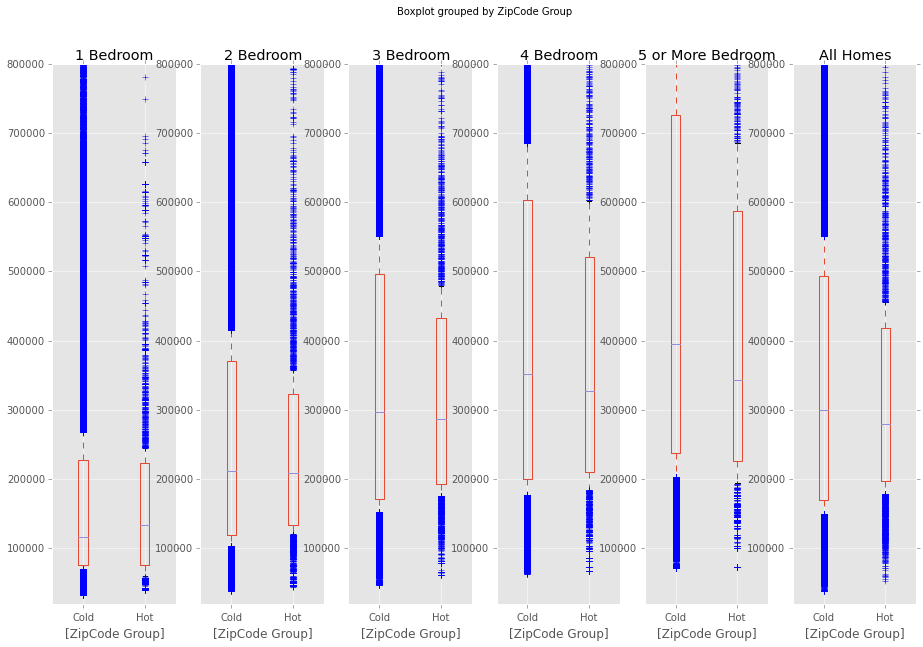

In [257]:
## compare home price grouped by targeted zip code

#pull only the columns related to selling price plus the label column PredictZipCode
dfPredictZipCodeFinalGraphHomePrice = dfPredictZipCodeFinalGraph[['1 Bedroom','2 Bedroom','3 Bedroom', \
                                                                  '4 Bedroom','5 or More Bedroom','All Homes', \
                                                                  'ZipCode Group']]
fig, axes = plt.subplots(1,6,figsize=(15,10)) #create fig with subplot of one row and six columns
for ax in fig.axes: #loop through the axes
    ax.set_ylim(20000,800000) #set y axis range
    ax.set_xlabel('ZipCode Group')
    
dfPredictZipCodeFinalGraphHomePrice.boxplot(by='ZipCode Group',ax=axes, whis=[20, 80]) #plot boxplot grouped by zipcode group

##RESULTS
#It seems that the "hot" zipcodes generally have less selling price across all sizes of home except one bedroom home

Estimated Rent per Square Foot
ZipCode Group                                
Cold                                 1.267083
Hot                                  1.312438

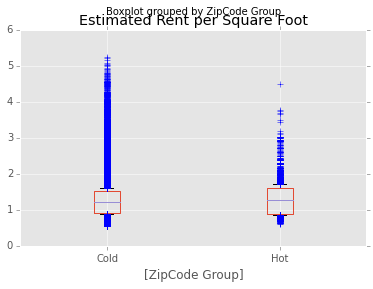

In [259]:
### Comparing "Estimated Rent per Square Foot" between hot and cold zipcodes
    
dfPredictZipCodeFinalGraph[['Estimated Rent per Square Foot','ZipCode Group']].boxplot(by='ZipCode Group', whis=[20, 80]) #plot boxplot grouped by zipcode group
dfPredictZipCodeFinalGraph[['Estimated Rent per Square Foot','ZipCode Group']].groupby('ZipCode Group').mean()

##Result
#"Hot" zipcodes has higher rent per square foot than "cold" zipcodes

Price-to-Rent Ratio
ZipCode Group                     
Cold                     15.183392
Hot                      16.311877

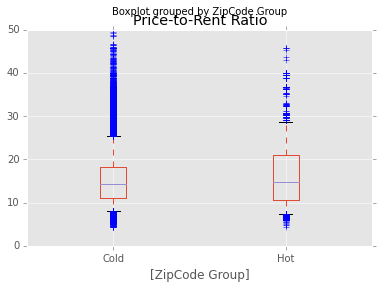

In [267]:
### Comparing Price-to-Rent Ratio between hot and cold zipcodes

dfPredictZipCodeFinalGraph[['Price-to-Rent Ratio','ZipCode Group']].boxplot(by='ZipCode Group', whis=[5, 95]) #plot boxplot grouped by zipcode group
dfPredictZipCodeFinalGraph[['Price-to-Rent Ratio','ZipCode Group']].groupby('ZipCode Group').mean()

##Result
#"Hot" zipcodes have higher price to rent ratio

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


AGI
ZipCode Group                      
Cold          count   412370.000000
              mean    411169.463179
              std     503631.325924
              min         29.000000
              25%      41620.000000
              50%     323732.000000
              75%     426559.000000
              max    6720840.000000
Hot           count     3095.000000
              mean    340720.915347
              std     236552.994016
              min       1072.000000
              25%     268839.000000
              50%     323732.000000
              75%     373113.000000
              max    2445018.000000

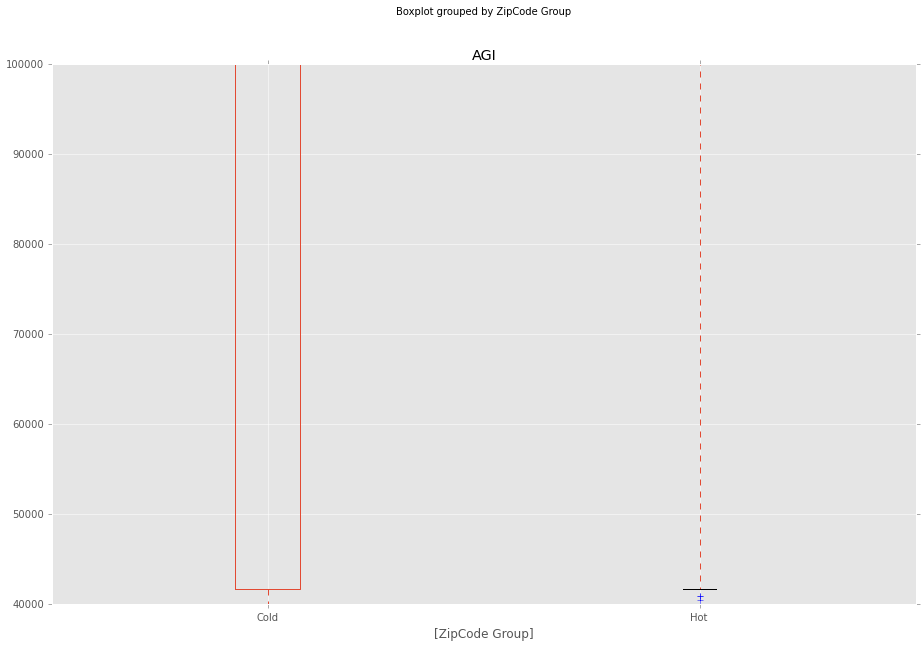

In [287]:
### Comparing AGI between hot and cold zipcodes

fig, axes = plt.subplots(1,1,figsize=(15,10)) #create fig with subplot of one row and six columns
for ax in fig.axes: #loop through the axes
    ax.set_ylim(40000,100000) #set y axis range
    ax.set_xlabel('ZipCode Group')

dfAPI = dfPredictZipCodeFinalGraph[['AGI','ZipCode Group']]
dfAPI['AGI'] = dtest1['AGI'].astype('float') #convert AGI column from object to float because groupby would have thrown error
dfAPI.boxplot(by='ZipCode Group', ax=axes, whis=[5, 95]) #plot boxplot grouped by zipcode group
dfAPI.groupby('ZipCode Group').describe()

##Result
#



             A                                       B                      \
lvl1         0         1         2         3         0         1         2   
lvl0                                                                         
0    -0.043879  1.559855 -0.816568 -1.153512 -0.955253  0.006054  0.549874   
1    -1.478906 -0.538327  0.245530 -0.557808 -0.388107  0.199452 -0.368337   
2     0.683293  0.580853  0.616548 -0.434614  0.266340 -0.559821 -1.540156   
3    -0.620344 -0.667595 -0.964356  2.184101  0.446906 -1.306462  0.456751   
4     2.636016 -0.620933  0.343482  0.460062 -0.501753  1.243370  1.345399   
5    -1.067563 -1.171373 -0.317838  0.060448  0.625931 -0.049140  0.678284   
6    -0.734326 -1.623022 -1.511070  1.102125 -0.401933  0.905841 -0.534978   
7    -0.454839 -0.475075 -0.138707 -0.604616  0.391817 -0.548800 -1.534456   
8     0.069288  0.288421  0.403373 -2.747532  0.642757 -0.850557 -0.155860   
9    -0.782015 -0.836552 -0.653908  0.230295  2.002810 -0.476204

OrderedDict([('A', {'boxes': [<matplotlib.lines.Line2D object at 0x0000000035526DA0>, <matplotlib.lines.Line2D object at 0x000000003553ED30>, <matplotlib.lines.Line2D object at 0x00000000353B3C18>, <matplotlib.lines.Line2D object at 0x000000003555BEF0>], 'fliers': [<matplotlib.lines.Line2D object at 0x000000003553E7B8>, <matplotlib.lines.Line2D object at 0x00000000353C0240>, <matplotlib.lines.Line2D object at 0x000000003555B978>, <matplotlib.lines.Line2D object at 0x0000000035582048>], 'medians': [<matplotlib.lines.Line2D object at 0x000000003553E240>, <matplotlib.lines.Line2D object at 0x00000000353C0198>, <matplotlib.lines.Line2D object at 0x000000003555B400>, <matplotlib.lines.Line2D object at 0x0000000035575A90>], 'means': [], 'whiskers': [<matplotlib.lines.Line2D object at 0x0000000035526908>, <matplotlib.lines.Line2D object at 0x000000003551CD68>, <matplotlib.lines.Line2D object at 0x00000000354EFF60>, <matplotlib.lines.Line2D object at 0x00000000354EFCF8>, <matplotlib.lines.Line

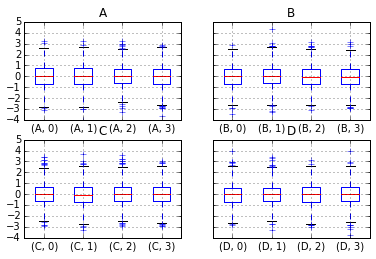

In [136]:
import pandas

import numpy as np
import itertools

# tuples = [t for t in itertools.product(range(1000), range(4))]
# index = pandas.MultiIndex.from_tuples(tuples, names=['lvl0', 'lvl1'])
# data = np.random.randn(len(index),4)
# df = pandas.DataFrame(data, columns=list('ABCD'), index=index)
grouped = df.groupby(level='lvl1')
# grouped.boxplot()
# df
# tuples
grouped = df.unstack(level='lvl1').groupby(level=0, axis=1)
print df.unstack(level='lvl1')
grouped.boxplot(subplots=True)

1 Bedroom  2 Bedroom  3 Bedroom  4 Bedroom  \
Month      ZipCode                                               
1996-04-30 90001        95100     108300     122700     130400   
           90002        79100      93700     113200     116800   
           90003        78600      91200     117900     118600   
           90004       112200     163600     223800     343700   
           90005       111000     136900     199700     322400   

                    5 or More Bedroom     AGI  All Homes    AverageAGI  \
Month      ZipCode                                                       
1996-04-30 90001               136900  284300     115200  19186.124983   
           90002               136900  284300     106800  19186.124983   
           90003               128000  284300     104700  19186.124983   
           90004               718200  284300     223900  19186.124983   
           90005               412400  284300     182300  19186.124983   

                    Condominiums DepedentExemptionsAmt  \
Month      ZipCode                                       
1996-04-30 90001          160100                 18773   
           90002          160100                 18773   
           90003          160100                 18773   
           90004          160100                 18773   
           90005          140700                 18773   

                    Estimated Rent per Square Foot  \
Month      ZipCode                                   
1996-04-30 90001                             1.570   
           90002                             1.542   
           90003                             1.564   
           90004                             1.658   
           90005                             1.558   

                    Estimated Rent, All Homes in Region ExemptionsRtn  \
Month      ZipCode                                                      
1996-04-30 90001                                   1595         37531   
           90002                                   1616         37531   
           90003                                   1608         37531   
           90004                                   2854         37531   
           90005                                   2467         37531   

                    Listings with Price Cut in Last 30 Days  \
Month      ZipCode                                            
1996-04-30 90001                                     2.4096   
           90002                                     5.7884   
           90003                                     4.6559   
           90004                                     8.8235   
           90005                                     9.3333   

                    Median List Price  Median List Price per Square Foot  \
Month      ZipCode                                                         
1996-04-30 90001               223900                         230.831409   
           90002               200000                         185.638298   
           90003               220000                         201.219512   
           90004               780000                         503.274559   
           90005               649000                         382.958353   

                    Median Rent, Homes Listed for Rent  Median Sale Price  \
Month      ZipCode                                                          
1996-04-30 90001                                  1200        113000.0000   
           90002                                  1695        103600.0000   
           90003                                  1395         96825.0000   
           90004                                  1500        276676.4706   
           90005                                  1450        185000.0000   

                    Median Sale Price per Square Foot  \
Month      ZipCode                                      
1996-04-30 90001                           102.134146   
           90002                            91.449100 

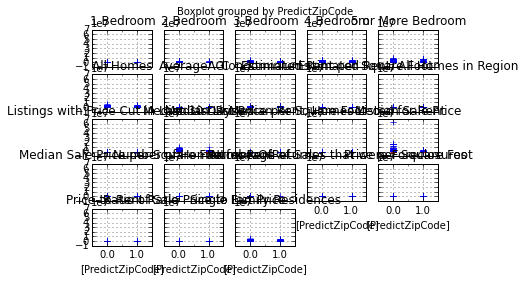

In [144]:
dfPredictZipCodeFinal3 = dfPredictZipCodeFinal.copy()
dfPredictZipCodeFinal3.set_index(['Month', 'ZipCode'],inplace=True)
dfPredictZipCodeFinal3.boxplot(by='PredictZipCode')
dfPredictZipCodeFinal3.head()

OrderedDict([('1 Bedroom', {'boxes': [<matplotlib.lines.Line2D object at 0x0000000290B43D30>, <matplotlib.lines.Line2D object at 0x0000000290B59390>], 'fliers': [<matplotlib.lines.Line2D object at 0x0000000290B4CDD8>, <matplotlib.lines.Line2D object at 0x0000000290AC64A8>], 'medians': [<matplotlib.lines.Line2D object at 0x0000000290B4C860>, <matplotlib.lines.Line2D object at 0x0000000290B68EF0>], 'means': [], 'whiskers': [<matplotlib.lines.Line2D object at 0x0000000290B43EF0>, <matplotlib.lines.Line2D object at 0x0000000290B43208>, <matplotlib.lines.Line2D object at 0x0000000290B598D0>, <matplotlib.lines.Line2D object at 0x0000000290B59E48>], 'caps': [<matplotlib.lines.Line2D object at 0x0000000290B37470>, <matplotlib.lines.Line2D object at 0x0000000290C6E240>, <matplotlib.lines.Line2D object at 0x0000000290B68400>, <matplotlib.lines.Line2D object at 0x0000000290B68978>]}), ('2 Bedroom', {'boxes': [<matplotlib.lines.Line2D object at 0x0000000290B43BA8>, <matplotlib.lines.Line2D object 

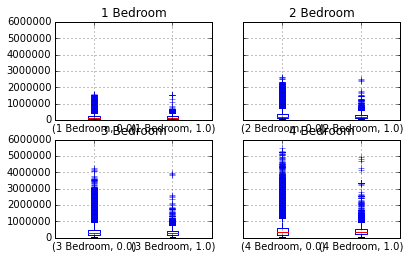

In [140]:
dfPredictZipCodeFinal2 = dfPredictZipCodeFinal.copy()
dfPredictZipCodeFinal2.set_index(['Month', 'ZipCode','PredictZipCode'],inplace=True)
dfPredictZipCodeFinal2 = dfPredictZipCodeFinal2.ix[:,0:4]
dfPredictZipCodeFinal2 = pd.DataFrame(dfPredictZipCodeFinal2.unstack())
# dfPredictZipCodeFinal3 = pd.DataFrame(dfPredictZipCodeFinal2['All Homes'])
# dfPredictZipCodeFinal2 = dfPredictZipCodeFinal2.T.reorder_levels([1,0]).T
dfPredictZipCodeFinal2 = dfPredictZipCodeFinal2.stack(level=1)
dfPredictZipCodeFinal2 = dfPredictZipCodeFinal2.unstack(level=2)
dfPredictZipCodeFinal2.columns.names = ['PredictZipCode','HomeCol']
dfPredictZipCodeFinal2
grouped = dfPredictZipCodeFinal2.groupby(axis=1, level=0)
grouped.boxplot(subplots=True)

# fig, ax1 = plt.subplots(figsize=(30, 6))
# fig.canvas.set_window_title('A Boxplot Example')
# plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

# bp = plt.boxplot(dfPredictZipCodeFinal2, notch=0, sym='+', vert=1, whis=1.5)
# plt.setp(bp['boxes'], color='black')
# plt.setp(bp['whiskers'], color='black')
# plt.setp(bp['fliers'], color='red', marker='+')

TypeError: 

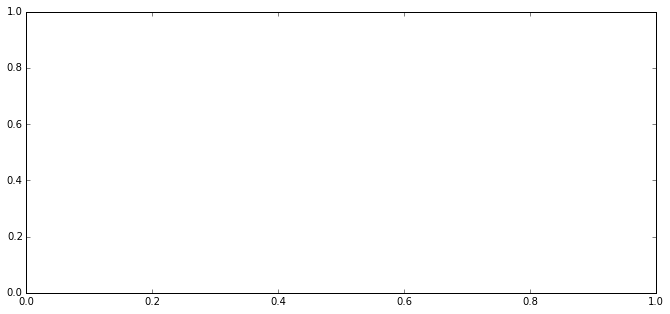

In [115]:
# pd.set_option('display.max_rows', 500)
# print sum(dfPredictZipCodeFinal.PredictZipCode)
# dfPredictZipCodeFinal.PredictZipCode.isnull

# print sum(dfPredictZipCodeFinal['PredictZipCode'].isnull().values)
# dfPredictZipCodeFinalnotstack['PredictZipCode'].fillna(value='test', inplace=True)
# # dfp1["preTestScore"].fillna(value=False , inplace=True)
# print sum(dfPredictZipCodeFinalnotstack['PredictZipCode'].isnull().values)
dfPredictZipCodeFinal.describe()

### simpe groupig analysis ###

## Find out the average value for columns such as all home price, average AGI, etc.. grouped by targeted zipcode and non targeted
# print dfPredictZipCodeFinal.groupby('PredictZipCode').mean()


# dfPredictZipCodeFinalBoxplot = dfPredictZipCodeFinal.set_index(['Month','ZipCode','PredictZipCode'])
# dfPredictZipCodeFinalBoxplot = dfPredictZipCodeFinalBoxplot.unstack(level=2)

dfPredictZipCodeFinal2 = dfPredictZipCodeFinal.copy()
dfPredictZipCodeFinal2.set_index(['Month', 'ZipCode','PredictZipCode'],inplace=True)
dfPredictZipCodeFinal2 = dfPredictZipCodeFinal2.ix[:,0:4]
dfPredictZipCodeFinal2 = pd.DataFrame(dfPredictZipCodeFinal2.unstack())
# dfPredictZipCodeFinal3 = pd.DataFrame(dfPredictZipCodeFinal2['All Homes'])
dfPredictZipCodeFinal2 = dfPredictZipCodeFinal2.T.reorder_levels([1,0]).T
dfPredictZipCodeFinal2 = dfPredictZipCodeFinal2.stack(level=1)
dfPredictZipCodeFinal2 = dfPredictZipCodeFinal2.unstack(level=2)
dfPredictZipCodeFinal2.columns.names = ['PredictZipCode','HomeCol']
dfPredictZipCodeFinalBoxplot = dfPredictZipCodeFinal2

numDists = 5
randomDists = ['Normal(1,1)', ' Lognormal(1,1)', 'Exp(1)', 'Gumbel(6,4)',
               'Triangular(2,9,11)']
N = 500
norm = np.random.normal(1, 1, N)
logn = np.random.lognormal(1, 1, N)
expo = np.random.exponential(1, N)
gumb = np.random.gumbel(6, 4, N)
tria = np.random.triangular(2, 9, 11, N)

# Generate some random indices that we'll use to resample the original data
# arrays. For code brevity, just use the same random indices for each array
bootstrapIndices = np.random.random_integers(0, N - 1, N)
normBoot = norm[bootstrapIndices]
expoBoot = expo[bootstrapIndices]
gumbBoot = gumb[bootstrapIndices]
lognBoot = logn[bootstrapIndices]
triaBoot = tria[bootstrapIndices]

data = [norm, normBoot, logn, lognBoot, expo, expoBoot, gumb, gumbBoot,
        tria, triaBoot]

fig, ax1 = plt.subplots(figsize=(10, 6))
fig.canvas.set_window_title('A Boxplot Example')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = plt.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

# Hide these grid behind plot objects
ax1.set_axisbelow(True)
ax1.set_title('Comparison of IID Bootstrap Resampling Across Five Distributions')
ax1.set_xlabel('Distribution')
ax1.set_ylabel('Value')

# Now fill the boxes with desired colors
boxColors = ['darkkhaki', 'royalblue']
numBoxes = numDists*2
medians = list(range(numBoxes))
for i in range(numBoxes):
    box = bp['boxes'][i]
    boxX = []
    boxY = []
    for j in range(5):
        boxX.append(box.get_xdata()[j])
        boxY.append(box.get_ydata()[j])
    boxCoords = list(zip(boxX, boxY))
    # Alternate between Dark Khaki and Royal Blue
    k = i % 2
    boxPolygon = Polygon(boxCoords, facecolor=boxColors[k])
    ax1.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    medianX = []
    medianY = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
        plt.plot(medianX, medianY, 'k')
        medians[i] = medianY[0]
    # Finally, overplot the sample averages, with horizontal alignment
    # in the center of each box
    plt.plot([np.average(med.get_xdata())], [np.average(data[i])],
             color='w', marker='*', markeredgecolor='k')

# Set the axes ranges and axes labels
ax1.set_xlim(0.5, numBoxes + 0.5)
top = 40
bottom = -5
ax1.set_ylim(bottom, top)
xtickNames = plt.setp(ax1, xticklabels=np.repeat(randomDists, 2))
plt.setp(xtickNames, rotation=45, fontsize=8)

# Due to the Y-axis scale being different across samples, it can be
# hard to compare differences in medians across the samples. Add upper
# X-axis tick labels with the sample medians to aid in comparison
# (just use two decimal places of precision)
pos = np.arange(numBoxes) + 1
upperLabels = [str(np.round(s, 2)) for s in medians]
weights = ['bold', 'semibold']
for tick, label in zip(range(numBoxes), ax1.get_xticklabels()):
    k = tick % 2
    ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
             horizontalalignment='center', size='x-small', weight=weights[k],
             color=boxColors[k])

# Finally, add a basic legend
plt.figtext(0.80, 0.08, str(N) + ' Random Numbers',
            backgroundcolor=boxColors[0], color='black', weight='roman',
            size='x-small')
plt.figtext(0.80, 0.045, 'IID Bootstrap Resample',
            backgroundcolor=boxColors[1],
            color='white', weight='roman', size='x-small')
plt.figtext(0.80, 0.015, '*', color='white', backgroundcolor='silver',
            weight='roman', size='medium')
plt.figtext(0.815, 0.013, ' Average Value', color='black', weight='roman',
            size='x-small')

plt.show()


# np.random.seed(123)
# all_data = [np.random.normal(0, std, 100) for std in range(1, 4)]
# all_data




# fig, axes = plt.subplots(ncols=3, sharey=True)
# fig.subplots_adjust(wspace=0)

# for ax, name in zip(axes, ['dataset1', 'dataset2', 'dataset3']):
#     ax.boxplot([data[name][item] for item in ['A', 'B', 'C']])
#     ax.set(xticklabels=['A', 'B', 'C'], xlabel=name)
#     ax.margins(0.05) # Optional

# plt.show()

# selectedZipCodes[selectedZipCodes[0] == True]

In [26]:
# dfPredictZipCodeFinalBoxplot = dfPredictZipCodeFinal.groupby('PredictZipCode')
dfPredictZipCodeFinalBoxplot = dfPredictZipCodeFinal.set_index(['Month','ZipCode','PredictZipCode'])
dfPredictZipCodeFinalBoxplot = dfPredictZipCodeFinalBoxplot.unstack(level=2)
dfPredictZipCodeFinalBoxplot.head()


1 Bedroom     2 Bedroom     3 Bedroom     4 Bedroom      \
PredictZipCode             0   1         0   1         0   1         0   1   
Month      ZipCode                                                           
1996-04-30 90001       95100 NaN    108300 NaN    122700 NaN    130400 NaN   
           90002       79100 NaN     93700 NaN    113200 NaN    116800 NaN   
           90003       78600 NaN     91200 NaN    117900 NaN    118600 NaN   
           90004      112200 NaN    163600 NaN    223800 NaN    343700 NaN   
           90005      111000 NaN    136900 NaN    199700 NaN    322400 NaN   

                   5 or More Bedroom         AGI      All Homes      \
PredictZipCode                     0   1       0    1         0   1   
Month      ZipCode                                                    
1996-04-30 90001              136900 NaN  284300  NaN    115200 NaN   
           90002              136900 NaN  284300  NaN    106800 NaN   
           90003              128000 NaN  284300  NaN    104700 NaN   
           90004              718200 NaN  284300  NaN    223900 NaN   
           90005              412400 NaN  284300  NaN    182300 NaN   

                      AverageAGI     Condominiums     DepedentExemptionsAmt  \
PredictZipCode                 0   1            0   1                     0   
Month      ZipCode                                                            
1996-04-30 90001    19186.124983 NaN       160100 NaN                 18773   
           90002    19186.124983 NaN       160100 NaN                 18773   
           90003    19186.124983 NaN       160100 NaN                 18773   
           90004    19186.124983 NaN       160100 NaN                 18773   
           90005    19186.124983 NaN       140700 NaN                 18773   

                        Estimated Rent per Square Foot      \
PredictZipCode        1                              0   1   
Month      ZipCode                                           
1996-04-30 90001    NaN                          1.570 NaN   
           90002    NaN                          1.542 NaN   
           90003    NaN                          1.564 NaN   
           90004    NaN                          1.658 NaN   
           90005    NaN                          1.558 NaN   

                   Estimated Rent, All Homes in Region     ExemptionsRtn       \
PredictZipCode                                       0   1             0    1   
Month      ZipCode                                                              
1996-04-30 90001                                  1595 NaN         37531  NaN   
           90002                                  1616 NaN         37531  NaN   
           90003                                  1608 NaN         37531  NaN   
           90004                                  2854 NaN         37531  NaN   
           90005                                  2467 NaN         37531  NaN   

                   Listings with Price Cut in Last 30 Days      \
PredictZipCode                                           0   1   
Month      ZipCode                                               
1996-04-30 90001                                    2.4096 NaN   
           90002                                    5.7884 NaN   
           90003                                    4.6559 NaN   
           90004                                    8.8235 NaN   
           90005                                    9.3333 NaN   

                   Median List Price     Median List Price per Square Foot  \
PredictZipCode                     0   1                                 0   
Month      ZipCode                                                           
1996-04-30 90001              223900 NaN                        230.831409   
           90002              200000 NaN                        185.638298   
           90003              220000 NaN                        201.219512   
           90004              780000 NaN         

In [27]:
### simpe groupig analysis ###


## the number of targeted zipcode in different year.  
dfPredictZipCodeFinal['Year'] = dfPredictZipCodeFinal.Month.str[:4]  # add a new column to store which year(first 4 digits of date) based on Month 
TargetZipCodeCount = pd.DataFrame(dfPredictZipCodeFinal.groupby(['Year','PredictZipCode']).count()['ZipCode'])
TargetZipCodeCount = TargetZipCodeCount.unstack(1)
TargetZipCodeCount = TargetZipCodeCount.rename(columns = {'ZipCode':'ZipCodeCount'})
TargetZipCodeCount.fillna(0,inplace=True)
TargetZipCodeCount

ZipCodeCount     
PredictZipCode            0    1
Year                            
1996                  11051    9
1997                  14878   31
1998                  29022   63
1999                  14911  458
2000                  14805  544
2001                  29043  105
2002                  28960  188
2003                  15073  295
2004                  28208  556
2005                  28413  387
2006                  28679   13
2007                  28763    4
2008                  23565    3
2009                  18602   10
2010                  18706    1
2011                  18834    1
2012                  17390   71
2013                  16504  286
2014                  16828   56
2015                  10135   14

In [28]:
### simpe groupig analysis ###

#for the zipcode ever consided to be targertted, find out for how many years they are selected as target
TargetedZipCodeCount = pd.DataFrame(dfPredictZipCodeFinal[dfPredictZipCodeFinal['PredictZipCode'] == True].groupby(['ZipCode'])['PredictZipCode'].count())
TargetedZipCodeCount.rename(columns = {'PredictZipCode':'PredictZipCodeCount'}, inplace = True)
TargetedZipCodeCount.sort('PredictZipCodeCount', ascending=False)
# sum(TargetedZipCodeCount['PredictZipCode'] > 1)

# dfPredictZipCodeFinal.groupby(['Month','ZipCode']).count()

PredictZipCodeCount
ZipCode                     
94609                     16
93280                     16
95113                     15
96093                     14
93501                     13
95811                     13
94301                     13
93426                     13
94022                     13
95070                     13
93307                     13
94619                     12
94611                     12
93241                     12
94610                     12
94602                     12
93271                     12
94306                     12
94109                     12
95033                     11
96052                     11
93306                     11
95814                     11
94618                     11
96057                     11
92236                     11
93250                     11
95129                     11
93701                     11
93203                     11
90014                     11
96145                     11
94117                     10
95131                     10
95452                     10
94305                     10
93953                     10
93223                     10
95820                     10
93309                     10
95030                     10
92539                     10
93650                     10
94114                     10
93721                     10
94511                      9
92311                      9
94124                      9
95134                      9
95987                      9
95255                      9
95120                      9
94041                      9
94925                      9
93215                      9
95338                      9
94710                      9
94709                      9
94706                      9
93257                      9
94040                      9
94131                      9
94043                      9
94599                      9
93277                      9
92277                      9
94107                      8
94024                      8
94085                      8
92223                      8
93449                      8
95051                      8
94087                      8
94110                      8
95123                      8
95111                      8
93664                      8
93923                      8
95050                      8
95470                      8
93313                      8
95627                      8
93238                      8
93267                      8
94704                      8
93268                      8
94707                      8
93422                      8
96067                      8
94595                      8
96025                      8
93274                      8
94574                      8
93242                      8
95008                      8
93263                      8
95010                      8
95014                      8
95329                      8
92386                      8
95326                      8
94515                      8
96146                      8
90802                      8
94502                      8
94924                      8
90006                      8
94703                      8
95562                      7
93662                      7
93221                      7
93648                      7
92570                      7
95132                      7
92252                      7
93305                      7
92356                      7
95445                      7
95461                      7
92321                      7
95135                      7
95422                      7
93304                      7
93265                      7
95126                      7
93553                      7
95125                      7
95124                      7
92256                      7
92543                      7
93602                      7
96161                      7
94403                      7
94038                      7
95054                      7
94702                      7
94086  

In [29]:
###  Prepare training and testing dataset
from sklearn.cross_validation import train_test_split

# separate aataset into training and testing set
X = dfPredictZipCodeFinal.copy()
X.set_index(['Month'],inplace=True) #putting back index of Monthly
# y = X['PredictZipCode'].values * 1  #set dependent variable PredictZipCode from dataframe
y = X['PredictZipCode']  #set dependent variable PredictZipCode from dataframe
X.drop('PredictZipCode',1,inplace=True) #remove PredictZipCode from dataframe

######################################## NEED TO DELETE HERE TO MAKE ENTIRE DATASET FOR MODELING LATER AFTER FULL TESTING
X = X.ix[20000:80000,:]
y = y[20000:80000]
######################################## NEED TO DELETE HERE TO MAKE ENTIRE DATASET FOR MODELING LATER AFTER FULL TESTING

# X_train, X_test, y_train, y_test = train_test_split(X.ix[20000:40000,:], y[20000:40000], test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print X_train.shape, X_test.shape, y_train.shape, y_test.shape

print sum(y_train)
#test to see if y has any true in the predicted y variable.  if no, I need better sample size
# if True in y_train:  
#     print "yes"
# else:
#     print "no"

(48000, 40) (12000, 40) (48000L,) (12000L,)
812.0


In [599]:
### Training prediction model

#LogisticRegression
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# clf = linear_model.LogisticRegression(C=1e5)
# clf.fit(X_train, y_train) 
y_pred = list(clf.predict(X_test))
print sum(y_pred)

#Evaluate model
print "accuracy store normalized:", accuracy_score(y_test, y_pred)
print "accuracy store normalized:", accuracy_score(y_test, y_pred, normalize=False)
print "F1 store binary:",f1_score(y_test, y_pred, average='binary')
print "F1 store micro:",f1_score(y_test, y_pred, average='micro')
print "F1 store weighted:",f1_score(y_test, y_pred, average='weighted') 

X_testsvm = X_test.copy()
X_testsvm['PredictZipCode'] = y_pred
X_testsvm['ZipCode'][X_testsvm['PredictZipCode'] == 1.0]


27.0
accuracy store normalized: 0.98275
accuracy store normalized: 11793
F1 store binary: 0.0717488789238
F1 store micro: 

C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:931: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:931: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


0.0717488789238
F1 store weighted: 0.0717488789238


In [609]:
# X_test
X_test['PredictZipCode'] = y_pred
X_test['ZipCode'][X_test['PredictZipCode'] == 1.0]


# ypd = pd.DataFrame(y_pred)
# ypd == Trues

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


Month
2000-02-29    94027
1999-08-31    94970
2000-07-31    94028
1999-05-31    94108
1999-10-31    94305
2000-02-29    94970
1999-01-31    94108
2000-07-31    93108
2000-07-31    94305
2000-07-31    94970
1999-04-30    94109
2000-01-31    94028
2000-07-31    95030
1998-10-31    96119
2000-06-30    94305
2000-04-30    95070
1999-11-30    94970
2000-07-31    94301
1999-01-31    94109
2000-05-31    94920
1998-10-31    96117
2000-05-31    94109
2000-01-31    94970
2000-06-30    94970
1999-12-31    94108
2000-06-30    94024
2000-07-31    94920
Name: ZipCode, dtype: object

In [626]:
### Training prediction model

#SVM
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

clfsvm = svm.SVC()
clfsvm.fit(X_train, y_train)  
y_predsvm = list(clfsvm.predict(X_test))
print sum(y_predsvm)

#Evaluate model
print "accuracy store normalized:", accuracy_score(y_test, y_predsvm)
print "accuracy store normalized:", accuracy_score(y_test, y_predsvm, normalize=False)
print "F1 store binary:",f1_score(y_test, y_predsvm, average='binary')
print "F1 store micro:",f1_score(y_test, y_predsvm, average='micro')
print "F1 store weighted:",f1_score(y_test, y_predsvm, average='weighted') 


NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
### This cell is trying to combine the individual california zipcode data .p pickle file into a singe file
### so the main analytic code can load all zipcodes and their distance difference into a single data frame.

import os
import glob
import pandas as pd
from os import path
path = '.\\DataPfiles\\'

calzipcodeAllLong = pd.DataFrame()    
for filename in glob.glob(os.path.join(path, 'calzip*.p')):
    calzipcodeAllLong = pd.concat([calzipcodeAllLong, pd.read_pickle(filename)], axis=1)

dfname = './DataPfiles/' + 'calzipcodeAllLong' + ".p"
pickle.dump( calzipcodeAllLong, open( dfname, "wb" ) )
print 'Done: ' + dfname

In [ ]:
##Abnormally Detection method TWO
##Find out zipcode in df..InZipCode which has z score > 2 and in df..AcrossZipCode among the 10 closest zipcodes which has z score > 2



### This cell is trying to calculate the distance between two zipcodes (within California) in miles
import pandas as pd
import pickle
from geopy.geocoders import Nominatim
from geopy.distance import vincenty
from math import radians, cos, sin, asin, sqrt
def calculateDistance(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km


geolocator = Nominatim()

zipcode = pd.read_csv('./DataPfiles/us_postal_codes.csv')
calzipcode = zipcode[zipcode.State == 'California']

startzipcodeIndex = int(100)    #last batch processed by script at test.ipynb
endzipcodeIndex = int(200)

for z in calzipcode.iloc[startzipcodeIndex:endzipcodeIndex,0]:
# for z in calzipcode.iloc[2:3,0]:
# for z in calzipcode['Postal Code']:    
    for i,r in calzipcode.iterrows():
        ziplon1 = calzipcode[calzipcode['Postal Code'] == int(z)]['Longitude']
        ziplat1 = calzipcode[calzipcode['Postal Code'] == int(z)]['Latitude']
        ziplon2 = r['Longitude']
        ziplat2 = r['Latitude']
        calzipcode.loc[i,z] = calculateDistance(ziplon1,ziplat1,ziplon2,ziplat2)

dfname = './DataPfiles/' + 'calzip' + str(int(calzipcode.iloc[startzipcodeIndex]['Postal Code'])) + "_to_" + str(int(calzipcode.iloc[endzipcodeIndex-1]['Postal Code'])) + ".p"
pickle.dump( calzipcode, open( dfname, "wb" ) )
print 'Done: ' + dfname
 
    
# geolocator = Nominatim()
# location = geolocator.geocode("94582")
# print(location.address)
# print((location.latitude, location.longitude))
# print(location.raw)

# # >> newport_ri = (41.49008, -71.312796)
# # >>> cleveland_oh = (41.499498, -81.695391)
# print(vincenty((geolocator.geocode("94582").latitude,geolocator.geocode("94582").longitude), (geolocator.geocode("94122").latitude,geolocator.geocode("94122").longitude)).miles)

In [ ]:
### This cell as well as the cell after this one are just my playground to play with different functions.  This is not part of the project. 


from pylab import plot, ylim, xlim, show, xlabel, ylabel
from numpy import linspace, loadtxt
import numpy as np

r=3.0

x = p.head()
y = pz

def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

# plot(x,y)
# xlim(0,1000)

x_av = movingaverage(x, r)
# plot(x_av, y)

# xlabel("Months since Jan 1749.")
# ylabel("No. of Sun spots")
# show()
print x_av

p = df11.iloc[:,0]  #ALl Homes price
pz = df11.iloc[:,-1] 
print pz


t1 = df.iloc[:,1] 
t2 = df3.iloc[:,0]
print "mean is % 4.3F and sd is % 4.3F " % (t1.mean(),t1.std
                                            
                                            # add a new column for moving average of All Homes price


p = df11.iloc[:,0] #ALl Homes price
pz = df11.iloc[:,-1] 


window_size = 3.0 #set the number of sample to gathering centered in the middle
movingave = lambda x: np.convolve(x, np.ones(int(window_size))/float(window_size), 'same')
transformed = df11.groupby('ZipCode')
transformed['All Homes'].transform(movingave)
# df11.info()

# df11 = df11[df11['All Homes'].isnull()]
grouped = df11[['All Homes','ZipCode']].groupby('ZipCode')
b = pd.DataFrame()
newdf = pd.DataFrame()
for name,group in grouped:
    g = group.copy()
#     print group.shape
#     print "size: % 3.2F" % movingaverage(group['All Homes'],3).size
#     if sum(g.isnull()) < 0:
#         g['Moving Ave'] = movingaverage(group['All Homes'],3)

#     print g.shape
#     print g.head()

    #     if(newdf.isnull):
#         newdf = g
#     newdf = newdf.append(g)
#     b = group['All Homes']
#     a = movingaverage(group['All Homes'],3)
    
#     group["MovingAve"] = np.convolve(group['All Homes'], np.ones(int(window_size))/float(window_size), 'same')
#     newdf = newdf.append(group)
# print b
# newdf
# newdf.info()
    
    


# df11['Moving Ave'] = movingaverage(df11.iloc[:,0], 3)  #para#1 is All Homes price; para#2 is numer of sample to gather centered in the middle

# df11.head()
x                                             

In [ ]:
np.average(dfAllHomes['93063'][(-1-y):-1])

In [ ]:
import pandas as pd
#dfAllHomesDiffFromMovAve

In [ ]:
print dfAllHomesStdDevAcrossZipCode.shape
# dfAllHomesStdDevAcrossZipCode
# np.sum(dfAllHomesStdDevAcrossZipCode > 2)

In [ ]:
#dfAllHomesDiffFromMovAve.mean(axis =1 )

In [ ]:
dfAllHomesDiffFromMovAve.std(axis = 1)

In [ ]:
from geopy.geocoders import Nominatim
from geopy.distance import vincenty

geolocator = Nominatim()
location = geolocator.geocode("94582")
print(location.address)
print((location.latitude, location.longitude))
print(location.raw)

# >> newport_ri = (41.49008, -71.312796)
# >>> cleveland_oh = (41.499498, -81.695391)
print(vincenty((geolocator.geocode("94582").latitude,geolocator.geocode("94582").longitude), (geolocator.geocode("94122").latitude,geolocator.geocode("94122").longitude)).miles)

In [ ]:
import pandas as pd
import pickle

df = pickle.load( open( ".\DataPfiles\calzip90001_to_90010.p", "rb" ) ) 

# print "abcde"
# zipcode = pd.read_csv('./DataPfiles/us_postal_codes.csv')
# calzipcode = zipcode[zipcode.State == 'California']

In [ ]:
import os
from os import path
files = [f for f in os.listdir(".\DataPfiles\\")]# if path.isfile(f)]
files
# print os.listdir(".\DataPfiles\\")

In [ ]:
PtoR = dfPriceToRent.mean()
print dfPriceToRent.mean(),dfPriceToRent.std()
print PtoR.mean(),PtoR.std()

highPtoRzip = pd.DataFrame(dfPriceToRent.mean() > 18)
highPtoRzip[highPtoRzip[0] == True]
# targetZipCodes[targetZipCodes[0] == True]

In [ ]:
# calzipcode = zipcode[zipcode.State == 'California']

# irsdata['ZipCode'] = irsdata['ZipCode'].str.strip()  #strip white space in the cell
# print sum(irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str)))  #match the rows in irsdata with calzipcode
# irsdata2007 = irsdata[irsdata['ZipCode'].isin(calzipcode['Postal Code'].apply(int).apply(str))]

# irsdata2007 = irsdata2007[irsdata2007['Range'] == ""]
# irsdata2007 = irsdata2007.drop('Range', axis=1, inplace=True)
# irsdata2007['AverageAGI'] = irsdata2007.AGI.astype(int) #/ irsdata2002['NumberOfReturns'])
# irsdata2007['NumberOfReturns'] = irsdata2007['NumberOfReturns'].astype(int)
# irsdata2007['AverageAGI'] = irsdata2007['AverageAGI'] * 1000 / irsdata2007.NumberOfReturns
# print irsdata2007['AverageAGI'].mean()


# irsdata = pd.read_csv('./DataPfiles/ZIPCode2006CA.csv',header=4, na_values=['**','--'])
# irsCol = ['ZipCode','NumberOfReturns','ExemptionsRtn','DepedentExemptionsAmt','AGI','SalariesWagesRtn','SalariesWagesAmt', \
#           'TaxableInterestRtn','TaxableInterestAmt', \
#           'TotalTaxRtn','TotalTaxAmt','ScheduleCTotalRtn','ScheduleFTotalRtn',\
#           'ScheduleARtn'
#           ]
# irsdata.columns= irsCol
# irsdata['ZipCode']

# print type(irsdata2007['Range'])
# import numpy as np
# L = [4,np.nan ,6]
# dftest = Series(L)
# dftest.apply(np.isnan)
# np.isNan(dftest)
# np.isnan()
# sum(irsdata2007.Range == "NaN")
# irsdata2007.Range 

dfPredictZipCodeFinal = pd.concat([dfPredictZipCode.unstack(level=1),irsdatafull.unstack(level=1)], axis=1)
dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1)
print "done"
dfPredictZipCodeFinal
# dfPredictZipCode.unstack(level=1)
# irsdatafull.unstack(level=1)

In [ ]:
# dfPredictZipCodeFinal = pd.concat([dfPredictZipCodeFinal.unstack(level=1),irsdata2001full.unstack(level=1)], axis=1)
# dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1)

# b = dfPredictZipCodeFinal.index.get_level_values(0) == '1998-09-30'  #for testing the result
# # b1 = dfPredictZipCodeFinal.index.get_level_values(0) == '2001-09-30'  #for testing the result
# dfPredictZipCodeFinal[b]  #for testing the result

# irsdatafull = irsdata1998full
# irsdatafull = irsdatafull.append(irsdata2001full)
# irsdatafull = irsdatafull.append(irsdata2002full)
# dfPredictZipCodeFinal = pd.concat([dfPredictZipCode.unstack(level=1),irsdatafull.unstack(level=1)], axis=1)
# dfPredictZipCodeFinal = dfPredictZipCodeFinal.stack(level=1)
# dfPredictZipCodeFinal

b = dfPredictZipCodeFinal.index.get_level_values(0) == '1998-09-30'  #for testing the result
b1 = dfPredictZipCodeFinal.index.get_level_values(0) == '2001-09-30'  #for testing the result
b2 = dfPredictZipCodeFinal.index.get_level_values(0) == '2002-09-30'  #for testing the result
b4 = dfPredictZipCodeFinal.index.get_level_values(0) == '2004-09-30'  #for testing the result
b5 = dfPredictZipCodeFinal.index.get_level_values(0) == '2005-09-30'  #for testing the result
b6 = dfPredictZipCodeFinal.index.get_level_values(0) == '2006-09-30'  #for testing the result
b7 = dfPredictZipCodeFinal.index.get_level_values(0) == '2007-09-30'  #for testing the result
b8 = dfPredictZipCodeFinal.index.get_level_values(0) == '2008-09-30'  #for testing the result
b9 = dfPredictZipCodeFinal.index.get_level_values(0) == '2009-09-30'  #for testing the result
b10 = dfPredictZipCodeFinal.index.get_level_values(0) == '2010-09-30'  #for testing the result
b11 = dfPredictZipCodeFinal.index.get_level_values(0) == '2011-09-30'  #for testing the result
dfPredictZipCodeFinal[b11].head(5)  #for testing the result

In [ ]:
dfPredictZipCodeFinal.info()
# dfPredictZipCodeFinal['TotalTaxAmt']

In [ ]:
dffinaltest = dfPredictZipCodeFinal.copy()
# dffinaltest.mean
dffinaltest1 = dffinaltest.fillna(method='backfill')
dffinaltest2 = dffinaltest1.dropna(axis=0,how='any')
dffinaltest2.describe().ix[:,10:36]
# dffinaltest2['SalariesWagesAmt']

In [ ]:
dffinaltest = dfPredictZipCodeFinal.copy()
# dffinaltest.mean
dffinaltest1 = dffinaltest.dropna()
dffinaltest1.info()
dffinaltest2 = dffinaltest1.mean(axis=0)
dffinaltest2
# dffinaltest1 = dffinaltest1.ix[:,0:2]
# dffinaltest1.mean(axis=0)

In [ ]:
dffinaltest = dfPredictZipCodeFinal.copy()
a = "nan"
# nalist = dffinaltest['DepedentExemptionsAmt'].str.contains("NaN", na=True)
# dffinaltest.ix[nalist,'DepedentExemptionsAmt'] == np.nan

# dffinaltest['DepedentExemptionsAmt'] = dffinaltest['DepedentExemptionsAmt'].convert_objects(convert_numeric=True)
dffinaltest = dffinaltest.convert_objects(convert_numeric=True)
# dffinaltest['DependentExemptionsAmt'] = dffinaltest['DependentExemptionsAmt'].astype(float)
dffinaltest2 = dffinaltest.fillna(dffinaltest.mean(numeric_only=True))

dffinaltest2['DepedentExemptionsAmt']

# dffinaltest['DepedentExemptionsAmt']
# pd.isnull(dffinaltest['DepedentExemptionsAmt'])

# dffinaltest['DepedentExemptionsAmt'].fillna("abc")
# dffinaltest['DepedentExemptionsAmt']
# a = np.nan
# np.isnan(a)
# type(a)